In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm, trange
import time
from scipy import stats
from scipy.optimize import minimize

from itertools import combinations

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

from utils import *
import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

ID_COL = 'APPLICATION_NUMBER'
TARGET= 'TARGET'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    if df[col].nunique() > 20:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str).fillna("NA"))
        
print("Before OHE", df.shape[1])
df, _ = get_encoded(df)
print("After OHE", df.shape[1])
data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X.shape

Memory usage of dataframe is 187.87 MB
Memory usage after optimization is: 87.74 MB
Decreased by 53.3%
Before OHE 100
After OHE 120


(110093, 119)

In [5]:
bureau = bki_cr()

history_train, target, history_test = prepare_history()
hist_importance = calculate_feature_separating_ability(history_train, target)

history_features = hist_importance[hist_importance > 0.005].index.tolist()
history_train = history_train[history_features + [ID_COL]]
history_test = history_test[history_features + [ID_COL]]

Final shapes: (110093, 172) (165141, 172)


In [6]:
X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [7]:
data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop([ID_COL, TARGET], axis=1, inplace=True)

In [8]:
ex_overall = ['NEW_CREDIT_TO_ANNUITY_RATIO', 
              'EXTERNAL_SCORING_RATING_3',
              'NAME_CONTRACT_TYPE', 
              'AMOUNT_ANNUITY', 
              'EXTERNAL_SCORING_RATING_2',
              'AGE', 
              'AMT_REQ_CREDIT_BUREAU_QRT', 
              'RATIO_AMOUNT_ANNUITY_TO_SALARY',
              'TOTAL_SALARY_COUNT_AGE_INTERVAL',
              'RATIO_AGE_TO_EXPERIENCE',
              'RATIO_CAR_TO_AGE', 
              'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY',
              'RATIO_CREDIT_TO_AGE', 
              'TOTAL_SALARY_MEAN_BY_EDUCATION',
              'AMT_REQ_CREDIT_BUREAU_YEAR', 
              'GENDER',
              'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 
              'EXTERNAL_SCORE_WEIGHTED',
              'EXTERNAL_SCORING_RATING_1', 
              'BURO_CREDIT_TYPE_Credit card_MEAN',
              'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN']

In [9]:
adv_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1,
                "eta": 0.02515321125271333,
                "gamma": 8.09734583146528,
                "max_depth": 6,
                "min_child_weight": 36
}

estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(adv_params, 
                                                            X[ex_overall], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=50)

Tue Sep 27 02:03:09 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76231, Valid score = 0.74798
Fold 2, Train score = 0.76341, Valid score = 0.72944
Fold 3, Train score = 0.76821, Valid score = 0.73379
Fold 4, Train score = 0.76785, Valid score = 0.73400
Fold 5, Train score = 0.77366, Valid score = 0.72386
Train score by each fold: [0.76231, 0.76341, 0.76821, 0.76785, 0.77366]
Valid score by each fold: [0.74798, 0.72944, 0.73379, 0.734, 0.72386]
Train mean score by each fold:0.76709 +/- 0.00403
Valid mean score by each fold:0.73381 +/- 0.00799
**************************************************
OOF-score: 0.73339


In [12]:
test_preds = estimators_xgb[0].predict(xgb.DMatrix(data_test[ex_overall]))

fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_preds})  # 0.73194
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/3.52M [00:00<?, ?B/s]
  6%|5         | 208k/3.52M [00:00<00:02, 1.70MB/s]
 53%|#####3    | 1.87M/3.52M [00:00<00:00, 3.64MB/s]
100%|##########| 3.52M/3.52M [00:02<00:00, 1.67MB/s]


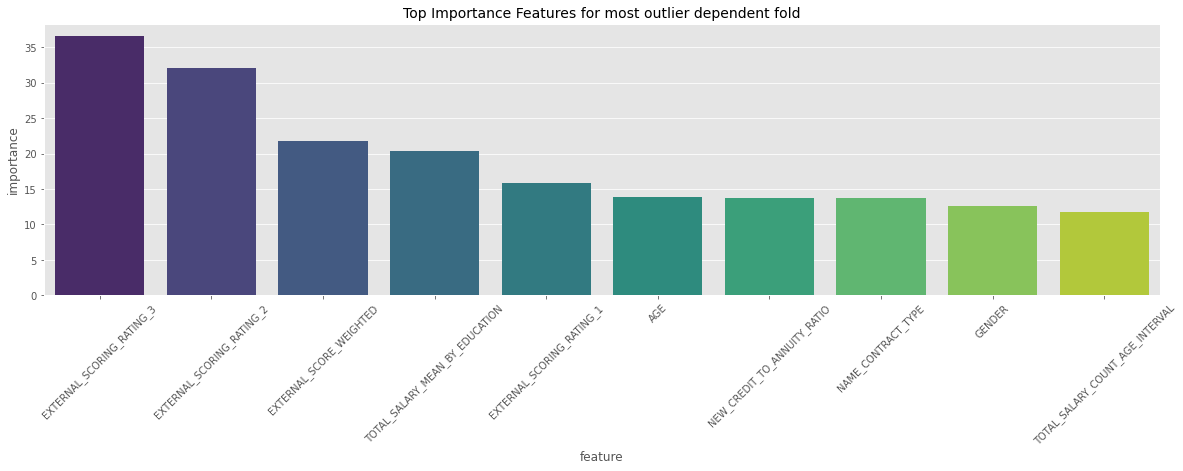

In [10]:
importances = estimators_xgb[0].get_score(importance_type='gain')

importance = pd.DataFrame(data={"feature": list(importances.keys()), "importance": list(importances.values())})
importance = importance.sort_values(by="importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["importance"], palette="viridis")
plt.title("Top Importance Features for most outlier dependent fold", size=14)
plt.xticks(rotation=45)
plt.show()

In [23]:
N = 16

test_preds = np.zeros((data_test.shape[0], N))

for i in trange(N):
    adv_params["random_state"] = seed + i
    fold = KFold(n_splits=5, shuffle=True, random_state=seed+i)

    estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(adv_params, X[ex_overall], y, cv=fold, rounds=50)
    running_scores = np.array([model.predict(xgb.DMatrix(data_test[ex_overall])) for model in estimators_xgb]).T
    test_preds[:, i] = np.mean(running_scores, axis=1)  # gmean/amean

test_preds = np.mean(test_preds, axis=1)
# test_preds = stats.gmean(test_preds, axis=1)
gc.collect()

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Mon Sep 26 22:45:51 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76231, Valid score = 0.74798
Fold 2, Train score = 0.76341, Valid score = 0.72944
Fold 3, Train score = 0.76821, Valid score = 0.73379
Fold 4, Train score = 0.76785, Valid score = 0.73400
Fold 5, Train score = 0.77366, Valid score = 0.72386
Train score by each fold: [0.76231, 0.76341, 0.76821, 0.76785, 0.77366]
Valid score by each fold: [0.74798, 0.72944, 0.73379, 0.734, 0.72386]
Train mean score by each fold:0.76709 +/- 0.00403
Valid mean score by each fold:0.73381 +/- 0.00799
**************************************************
OOF-score: 0.73339


  6%|█████▏                                                                            | 1/16 [02:42<40:41, 162.75s/it]

Mon Sep 26 22:48:33 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76958, Valid score = 0.73844
Fold 2, Train score = 0.77375, Valid score = 0.72705
Fold 3, Train score = 0.77077, Valid score = 0.73578
Fold 4, Train score = 0.76520, Valid score = 0.73600
Fold 5, Train score = 0.76894, Valid score = 0.73081
Train score by each fold: [0.76958, 0.77375, 0.77077, 0.7652, 0.76894]
Valid score by each fold: [0.73844, 0.72705, 0.73578, 0.736, 0.73081]
Train mean score by each fold:0.76965 +/- 0.00277
Valid mean score by each fold:0.73362 +/- 0.00411
**************************************************
OOF-score: 0.73320


 12%|██████████▎                                                                       | 2/16 [05:58<42:27, 181.96s/it]

Mon Sep 26 22:51:49 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.77074, Valid score = 0.72938
Fold 2, Train score = 0.76857, Valid score = 0.73145
Fold 3, Train score = 0.76473, Valid score = 0.73574
Fold 4, Train score = 0.77194, Valid score = 0.74018
Fold 5, Train score = 0.76933, Valid score = 0.72785
Train score by each fold: [0.77074, 0.76857, 0.76473, 0.77194, 0.76933]
Valid score by each fold: [0.72938, 0.73145, 0.73574, 0.74018, 0.72785]
Train mean score by each fold:0.76906 +/- 0.00246
Valid mean score by each fold:0.73292 +/- 0.00450
**************************************************
OOF-score: 0.73255


 19%|███████████████▍                                                                  | 3/16 [09:13<40:46, 188.20s/it]

Mon Sep 26 22:55:04 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76767, Valid score = 0.73938
Fold 2, Train score = 0.77218, Valid score = 0.73874
Fold 3, Train score = 0.76064, Valid score = 0.72012
Fold 4, Train score = 0.77001, Valid score = 0.72138
Fold 5, Train score = 0.77378, Valid score = 0.73986
Train score by each fold: [0.76767, 0.77218, 0.76064, 0.77001, 0.77378]
Valid score by each fold: [0.73938, 0.73874, 0.72012, 0.72138, 0.73986]
Train mean score by each fold:0.76886 +/- 0.00459
Valid mean score by each fold:0.73190 +/- 0.00912
**************************************************
OOF-score: 0.73171


 25%|████████████████████▌                                                             | 4/16 [12:37<38:54, 194.50s/it]

Mon Sep 26 22:58:29 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.75584, Valid score = 0.74006
Fold 2, Train score = 0.77044, Valid score = 0.73722
Fold 3, Train score = 0.77603, Valid score = 0.72468
Fold 4, Train score = 0.76460, Valid score = 0.73938
Fold 5, Train score = 0.76194, Valid score = 0.72126
Train score by each fold: [0.75584, 0.77044, 0.77603, 0.7646, 0.76194]
Valid score by each fold: [0.74006, 0.73722, 0.72468, 0.73938, 0.72126]
Train mean score by each fold:0.76577 +/- 0.00695
Valid mean score by each fold:0.73252 +/- 0.00793
**************************************************
OOF-score: 0.73243


 31%|█████████████████████████▋                                                        | 5/16 [15:28<34:03, 185.74s/it]

Mon Sep 26 23:01:19 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76627, Valid score = 0.74152
Fold 2, Train score = 0.76579, Valid score = 0.72852
Fold 3, Train score = 0.77271, Valid score = 0.73480
Fold 4, Train score = 0.77374, Valid score = 0.73076
Fold 5, Train score = 0.77784, Valid score = 0.73214
Train score by each fold: [0.76627, 0.76579, 0.77271, 0.77374, 0.77784]
Valid score by each fold: [0.74152, 0.72852, 0.7348, 0.73076, 0.73214]
Train mean score by each fold:0.77127 +/- 0.00461
Valid mean score by each fold:0.73355 +/- 0.00448
**************************************************
OOF-score: 0.73331


 38%|██████████████████████████████▊                                                   | 6/16 [19:10<33:02, 198.25s/it]

Mon Sep 26 23:05:01 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76696, Valid score = 0.72657
Fold 2, Train score = 0.76720, Valid score = 0.72814
Fold 3, Train score = 0.77020, Valid score = 0.73315
Fold 4, Train score = 0.76577, Valid score = 0.73564
Fold 5, Train score = 0.76563, Valid score = 0.74106
Train score by each fold: [0.76696, 0.7672, 0.7702, 0.76577, 0.76563]
Valid score by each fold: [0.72657, 0.72814, 0.73315, 0.73564, 0.74106]
Train mean score by each fold:0.76715 +/- 0.00165
Valid mean score by each fold:0.73291 +/- 0.00523
**************************************************
OOF-score: 0.73253


 44%|███████████████████████████████████▉                                              | 7/16 [22:09<28:46, 191.81s/it]

Mon Sep 26 23:08:00 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76421, Valid score = 0.73161
Fold 2, Train score = 0.77190, Valid score = 0.72704
Fold 3, Train score = 0.77079, Valid score = 0.74139
Fold 4, Train score = 0.76694, Valid score = 0.73618
Fold 5, Train score = 0.77268, Valid score = 0.72825
Train score by each fold: [0.76421, 0.7719, 0.77079, 0.76694, 0.77268]
Valid score by each fold: [0.73161, 0.72704, 0.74139, 0.73618, 0.72825]
Train mean score by each fold:0.76930 +/- 0.00322
Valid mean score by each fold:0.73289 +/- 0.00530
**************************************************
OOF-score: 0.73247


 50%|█████████████████████████████████████████                                         | 8/16 [25:26<25:49, 193.69s/it]

Mon Sep 26 23:11:18 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.75903, Valid score = 0.74364
Fold 2, Train score = 0.75562, Valid score = 0.73490
Fold 3, Train score = 0.76970, Valid score = 0.73141
Fold 4, Train score = 0.76978, Valid score = 0.73100
Fold 5, Train score = 0.76778, Valid score = 0.72242
Train score by each fold: [0.75903, 0.75562, 0.7697, 0.76978, 0.76778]
Valid score by each fold: [0.74364, 0.7349, 0.73141, 0.731, 0.72242]
Train mean score by each fold:0.76438 +/- 0.00591
Valid mean score by each fold:0.73267 +/- 0.00685
**************************************************
OOF-score: 0.73244


 56%|██████████████████████████████████████████████▏                                   | 9/16 [27:58<21:04, 180.61s/it]

Mon Sep 26 23:13:49 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76140, Valid score = 0.73744
Fold 2, Train score = 0.76876, Valid score = 0.74470
Fold 3, Train score = 0.77132, Valid score = 0.72598
Fold 4, Train score = 0.76547, Valid score = 0.72244
Fold 5, Train score = 0.76918, Valid score = 0.73384
Train score by each fold: [0.7614, 0.76876, 0.77132, 0.76547, 0.76918]
Valid score by each fold: [0.73744, 0.7447, 0.72598, 0.72244, 0.73384]
Train mean score by each fold:0.76723 +/- 0.00346
Valid mean score by each fold:0.73288 +/- 0.00798
**************************************************
OOF-score: 0.73251


 62%|██████████████████████████████████████████████████▋                              | 10/16 [31:01<18:07, 181.17s/it]

Mon Sep 26 23:16:52 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.77574, Valid score = 0.73350
Fold 2, Train score = 0.76358, Valid score = 0.74205
Fold 3, Train score = 0.77046, Valid score = 0.74859
Fold 4, Train score = 0.76603, Valid score = 0.72415
Fold 5, Train score = 0.76872, Valid score = 0.71655
Train score by each fold: [0.77574, 0.76358, 0.77046, 0.76603, 0.76872]
Valid score by each fold: [0.7335, 0.74205, 0.74859, 0.72415, 0.71655]
Train mean score by each fold:0.76891 +/- 0.00414
Valid mean score by each fold:0.73297 +/- 0.01161
**************************************************
OOF-score: 0.73289


 69%|███████████████████████████████████████████████████████▋                         | 11/16 [34:24<15:40, 188.00s/it]

Mon Sep 26 23:20:15 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76893, Valid score = 0.73625
Fold 2, Train score = 0.76970, Valid score = 0.72183
Fold 3, Train score = 0.75708, Valid score = 0.72985
Fold 4, Train score = 0.75179, Valid score = 0.73568
Fold 5, Train score = 0.77486, Valid score = 0.73353
Train score by each fold: [0.76893, 0.7697, 0.75708, 0.75179, 0.77486]
Valid score by each fold: [0.73625, 0.72183, 0.72985, 0.73568, 0.73353]
Train mean score by each fold:0.76447 +/- 0.00861
Valid mean score by each fold:0.73143 +/- 0.00530
**************************************************
OOF-score: 0.73114


 75%|████████████████████████████████████████████████████████████▊                    | 12/16 [37:09<12:03, 180.93s/it]

Mon Sep 26 23:23:00 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76423, Valid score = 0.73009
Fold 2, Train score = 0.75652, Valid score = 0.74073
Fold 3, Train score = 0.76946, Valid score = 0.73310
Fold 4, Train score = 0.76251, Valid score = 0.72374
Fold 5, Train score = 0.76668, Valid score = 0.73348
Train score by each fold: [0.76423, 0.75652, 0.76946, 0.76251, 0.76668]
Valid score by each fold: [0.73009, 0.74073, 0.7331, 0.72374, 0.73348]
Train mean score by each fold:0.76388 +/- 0.00436
Valid mean score by each fold:0.73223 +/- 0.00550
**************************************************
OOF-score: 0.73193


 81%|█████████████████████████████████████████████████████████████████▊               | 13/16 [39:36<08:32, 170.73s/it]

Mon Sep 26 23:25:27 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76097, Valid score = 0.73414
Fold 2, Train score = 0.75759, Valid score = 0.73320
Fold 3, Train score = 0.77022, Valid score = 0.72733
Fold 4, Train score = 0.76378, Valid score = 0.73328
Fold 5, Train score = 0.72595, Valid score = 0.71530
Train score by each fold: [0.76097, 0.75759, 0.77022, 0.76378, 0.72595]
Valid score by each fold: [0.73414, 0.7332, 0.72733, 0.73328, 0.7153]
Train mean score by each fold:0.75570 +/- 0.01544
Valid mean score by each fold:0.72865 +/- 0.00710
**************************************************
OOF-score: 0.70512


 88%|██████████████████████████████████████████████████████████████████████▉          | 14/16 [41:30<05:07, 153.61s/it]

Mon Sep 26 23:27:21 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.77052, Valid score = 0.73124
Fold 2, Train score = 0.76333, Valid score = 0.74314
Fold 3, Train score = 0.76837, Valid score = 0.72744
Fold 4, Train score = 0.76794, Valid score = 0.73859
Fold 5, Train score = 0.75529, Valid score = 0.72194
Train score by each fold: [0.77052, 0.76333, 0.76837, 0.76794, 0.75529]
Valid score by each fold: [0.73124, 0.74314, 0.72744, 0.73859, 0.72194]
Train mean score by each fold:0.76509 +/- 0.00543
Valid mean score by each fold:0.73247 +/- 0.00760
**************************************************
OOF-score: 0.73201


 94%|███████████████████████████████████████████████████████████████████████████▉     | 15/16 [44:09<02:35, 155.26s/it]

Mon Sep 26 23:30:01 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.77206, Valid score = 0.74255
Fold 2, Train score = 0.78010, Valid score = 0.71966
Fold 3, Train score = 0.76525, Valid score = 0.73218
Fold 4, Train score = 0.76613, Valid score = 0.73277
Fold 5, Train score = 0.76611, Valid score = 0.74139
Train score by each fold: [0.77206, 0.7801, 0.76525, 0.76613, 0.76611]
Valid score by each fold: [0.74255, 0.71966, 0.73218, 0.73277, 0.74139]
Train mean score by each fold:0.76993 +/- 0.00564
Valid mean score by each fold:0.73371 +/- 0.00822
**************************************************
OOF-score: 0.73319


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [47:36<00:00, 178.51s/it]


3821

In [27]:
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_preds})  # 0.73329
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.89M [00:00<?, ?B/s]
  4%|4         | 216k/4.89M [00:00<00:02, 1.82MB/s]
 41%|####1     | 2.02M/4.89M [00:00<00:00, 3.90MB/s]
100%|##########| 4.89M/4.89M [00:02<00:00, 2.36MB/s]


### LGBM feature selection + hyperparameter tunning

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
gc.collect()

4484

In [12]:
lgbm_params_my = {
                'boosting_type': 'gbdt',
                'n_estimators': 700,  # 2000
                'subsample_for_bin': 240000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'colsample_bytree': 0.508716,
                'min_split_gain': 0.024766,
                'subsample': 0.7,
                'is_unbalance': False,
                'random_state': seed,
                'silent': -1,
                'learning_rate': 0.005134,
                'max_depth': 4,  # 10
                'min_child_weight': 262,
                'num_leaves': 54,
                'min_child_samples': 54,
                
}

In [13]:
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [00:24<00:00,  7.45it/s]


In [14]:
perm = deltas[deltas > 0].index.tolist()

In [9]:
perm = ['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 'AGE',
        'EXT_SCORES_min', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'EXT_SCORES_nanmedian', 'ANNUITY_JOB',
        'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'RATIO_ANNUITY_TO_AGE', 'EDUCATION_FAMILY_STATUS',
        'EXT_SCORES_max', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'GENDER', 'RATIO_AGE_TO_EXPERIENCE', 'RATIO_CREDIT_TO_AGE',
        'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'AMOUNT_ANNUITY',
        'TOTAL_SALARY_MIN_BY_EDUCATION', 'AMOUNT_ANNUITY_MIN_AGE_INTERVAL', 'RATIO_AMOUNT_ANNUITY_TO_SALARY',
        'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AGE_BIN', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'AMOUNT_PAYMENT_MAX', 'CREDIT_JOB',
        'OWN_CAR_AGE', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'BURO_CREDIT_TYPE_Credit card_MEAN', 'DAYS_ON_LAST_JOB',
        'EXT_SCORE_2_ANNUITY', 'BKI_REQUESTS_COUNT', 'EXT_SCORES_var', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
        'EXTERNAL_SCORING_RATING_1', 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'RATIO_CAR_TO_AGE',
        'BURO_CREDIT_TYPE_Consumer credit_MEAN', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_AGE_INTERVAL',
        'TOTAL_SALARY_MAX_BY_EDUCATION', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'DAYS_LAST_DUE_1ST_VERSION_SUM',
        'AMOUNT_ANNUITY_COUNT_AGE_INTERVAL', 'AMOUNT_CREDIT', 'AMOUNT_CREDIT_COUNT_BY_FAMILY_STATUS',
        'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 'AMOUNT_ANNUITY_MAX_AGE_INTERVAL', 'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS',
        'EXTERNAL_SCORING_RATING_2', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 'AMOUNT_ANNUITY_COUNT_BY_FAMILY_STATUS',
        'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'SALARY_JOB',
        'NAME_GOODS_CATEGORY_CONSUMERELECTRONICS_MAX', 'BURO_CREDIT_TYPE_Mortgage_MEAN']

In [15]:
best_selector = BestSet(lgbm_params_my, k_features=40).fit(X[perm], y)

In [22]:
exhaust = X[perm].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])].tolist()

In [10]:
exhaust = ['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 'AGE', 
           'EXT_SCORES_min', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'ANNUITY_JOB', 
           'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EXT_SCORES_max', 'GENDER', 'RATIO_AGE_TO_EXPERIENCE', 
           'RATIO_CREDIT_TO_AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 
           'AMOUNT_ANNUITY', 'TOTAL_SALARY_MIN_BY_EDUCATION', 'AMOUNT_ANNUITY_MIN_AGE_INTERVAL', 
           'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AGE_BIN', 'AMOUNT_PAYMENT_MAX', 'CREDIT_JOB', 
           'OWN_CAR_AGE', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'BURO_CREDIT_TYPE_Credit card_MEAN', 'DAYS_ON_LAST_JOB', 
           'BKI_REQUESTS_COUNT', 'EXT_SCORES_var', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL', 'EXTERNAL_SCORING_RATING_1',
           'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 
           'BURO_CREDIT_TYPE_Consumer credit_MEAN', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_AGE_INTERVAL',
           'TOTAL_SALARY_MAX_BY_EDUCATION', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'AMOUNT_ANNUITY_COUNT_AGE_INTERVAL', 
           'AMOUNT_CREDIT', 'AMOUNT_CREDIT_COUNT_BY_FAMILY_STATUS', 'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 
           'AMOUNT_ANNUITY_MAX_AGE_INTERVAL', 'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'EXTERNAL_SCORING_RATING_2',
           'RATIO_SALARY_TO_AMOUNT_CREDIT', 'AMOUNT_ANNUITY_COUNT_BY_FAMILY_STATUS', 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 
           'SALARY_JOB', 'NAME_GOODS_CATEGORY_CONSUMERELECTRONICS_MAX', 'BURO_CREDIT_TYPE_Mortgage_MEAN']

In [207]:
start_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 5000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 255,
}


def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 5, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 150),
                    'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 150)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 X[ex_overall], 
                                                 y, 
                                                 cv=fold, 
                                                 rounds=50,
                                                 verbose=False)
    
    
    return score

In [208]:
%%time
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=12000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

[I 2022-09-28 19:20:17,644] A new study created in memory with name: no-name-d37f0f65-5006-4b85-9fb1-d2e36655f4db
[I 2022-09-28 19:20:21,481] Trial 0 finished with value: 0.731356 and parameters: {'max_depth': 7, 'learning_rate': 0.0951207163345817, 'num_leaves': 112, 'min_child_samples': 184, 'min_child_weight': 23.403640047725037}. Best is trial 0 with value: 0.731356.
[I 2022-09-28 19:20:49,456] Trial 1 finished with value: 0.732288 and parameters: {'max_depth': 6, 'learning_rate': 0.006750277604651747, 'num_leaves': 131, 'min_child_samples': 184, 'min_child_weight': 106.21117859682903}. Best is trial 1 with value: 0.732288.
[I 2022-09-28 19:20:54,274] Trial 2 finished with value: 0.7326919999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.09702107536403744, 'num_leaves': 126, 'min_child_samples': 71, 'min_child_weight': 27.274563256097885}. Best is trial 2 with value: 0.7326919999999999.
[I 2022-09-28 19:21:02,157] Trial 3 finished with value: 0.732734 and parameters: {'

[I 2022-09-28 19:24:16,449] Trial 29 finished with value: 0.732596 and parameters: {'max_depth': 8, 'learning_rate': 0.0867419753612744, 'num_leaves': 17, 'min_child_samples': 192, 'min_child_weight': 16.97361401546234}. Best is trial 8 with value: 0.7341000000000001.
[I 2022-09-28 19:24:21,933] Trial 30 finished with value: 0.732714 and parameters: {'max_depth': 11, 'learning_rate': 0.059394098002043504, 'num_leaves': 46, 'min_child_samples': 280, 'min_child_weight': 38.11058082043705}. Best is trial 8 with value: 0.7341000000000001.
[I 2022-09-28 19:24:28,509] Trial 31 finished with value: 0.733336 and parameters: {'max_depth': 6, 'learning_rate': 0.047894643977061835, 'num_leaves': 111, 'min_child_samples': 247, 'min_child_weight': 51.25108307120711}. Best is trial 8 with value: 0.7341000000000001.
[I 2022-09-28 19:24:38,873] Trial 32 finished with value: 0.733718 and parameters: {'max_depth': 5, 'learning_rate': 0.02664375043199416, 'num_leaves': 71, 'min_child_samples': 253, 'min_

[I 2022-09-28 19:29:04,260] Trial 58 finished with value: 0.732032 and parameters: {'max_depth': 9, 'learning_rate': 0.06474230189066, 'num_leaves': 61, 'min_child_samples': 262, 'min_child_weight': 40.80977073618508}. Best is trial 51 with value: 0.734152.
[I 2022-09-28 19:29:10,414] Trial 59 finished with value: 0.7330620000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.05202064592405625, 'num_leaves': 12, 'min_child_samples': 217, 'min_child_weight': 8.140317708044261}. Best is trial 51 with value: 0.734152.
[I 2022-09-28 19:29:27,729] Trial 60 finished with value: 0.732458 and parameters: {'max_depth': 11, 'learning_rate': 0.01641580669255245, 'num_leaves': 41, 'min_child_samples': 270, 'min_child_weight': 133.8086303657662}. Best is trial 51 with value: 0.734152.
[I 2022-09-28 19:29:33,108] Trial 61 finished with value: 0.7328319999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.05751640517336519, 'num_leaves': 12, 'min_child_samples': 29, 'min_child_weigh

[I 2022-09-28 19:32:51,585] Trial 88 finished with value: 0.733584 and parameters: {'max_depth': 10, 'learning_rate': 0.04622219788331543, 'num_leaves': 15, 'min_child_samples': 206, 'min_child_weight': 15.815394715958837}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:32:59,879] Trial 89 finished with value: 0.732078 and parameters: {'max_depth': 12, 'learning_rate': 0.04413707163198778, 'num_leaves': 76, 'min_child_samples': 267, 'min_child_weight': 49.33956448673577}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:33:13,779] Trial 90 finished with value: 0.720912 and parameters: {'max_depth': 5, 'learning_rate': 0.0056676510810670586, 'num_leaves': 35, 'min_child_samples': 87, 'min_child_weight': 80.50895261340114}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:33:19,473] Trial 91 finished with value: 0.732488 and parameters: {'max_depth': 10, 'learning_rate': 0.04622809271651507, 'num_leaves': 15, 'min_child_samples': 207, 'min_child_weight': 15.4032441833

[I 2022-09-28 19:37:10,643] Trial 118 finished with value: 0.7330540000000001 and parameters: {'max_depth': 9, 'learning_rate': 0.033647543020988824, 'num_leaves': 18, 'min_child_samples': 127, 'min_child_weight': 80.7988144348355}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:37:16,317] Trial 119 finished with value: 0.7337680000000001 and parameters: {'max_depth': 10, 'learning_rate': 0.056117753989730804, 'num_leaves': 23, 'min_child_samples': 39, 'min_child_weight': 56.52673788908533}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:37:22,623] Trial 120 finished with value: 0.733328 and parameters: {'max_depth': 10, 'learning_rate': 0.056359188845708376, 'num_leaves': 33, 'min_child_samples': 26, 'min_child_weight': 42.43549717396836}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:37:28,660] Trial 121 finished with value: 0.733744 and parameters: {'max_depth': 10, 'learning_rate': 0.05376686784715379, 'num_leaves': 22, 'min_child_samples': 248, 'min_child_

[I 2022-09-28 19:40:17,373] Trial 148 finished with value: 0.7342139999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.06438233109807215, 'num_leaves': 10, 'min_child_samples': 10, 'min_child_weight': 52.623072952239724}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:40:23,913] Trial 149 finished with value: 0.734094 and parameters: {'max_depth': 12, 'learning_rate': 0.06428271795212283, 'num_leaves': 10, 'min_child_samples': 14, 'min_child_weight': 51.31128354618128}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:40:30,943] Trial 150 finished with value: 0.733762 and parameters: {'max_depth': 12, 'learning_rate': 0.06462969374422563, 'num_leaves': 9, 'min_child_samples': 11, 'min_child_weight': 37.00762775521923}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:40:35,963] Trial 151 finished with value: 0.73414 and parameters: {'max_depth': 11, 'learning_rate': 0.07409493466725338, 'num_leaves': 11, 'min_child_samples': 16, 'min_child_weight': 52.55

[I 2022-09-28 19:43:23,500] Trial 178 finished with value: 0.732968 and parameters: {'max_depth': 10, 'learning_rate': 0.03927978610139722, 'num_leaves': 8, 'min_child_samples': 52, 'min_child_weight': 35.221846938263894}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:43:31,107] Trial 179 finished with value: 0.733418 and parameters: {'max_depth': 11, 'learning_rate': 0.04107376243978744, 'num_leaves': 11, 'min_child_samples': 31, 'min_child_weight': 31.66341303729825}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:43:38,858] Trial 180 finished with value: 0.733642 and parameters: {'max_depth': 10, 'learning_rate': 0.04282637075282419, 'num_leaves': 14, 'min_child_samples': 41, 'min_child_weight': 28.62367466706889}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:43:45,472] Trial 181 finished with value: 0.733282 and parameters: {'max_depth': 11, 'learning_rate': 0.04540095192289488, 'num_leaves': 21, 'min_child_samples': 21, 'min_child_weight': 35.78750855724

[I 2022-09-28 19:47:20,103] Trial 208 finished with value: 0.73381 and parameters: {'max_depth': 12, 'learning_rate': 0.03941125843128548, 'num_leaves': 12, 'min_child_samples': 19, 'min_child_weight': 43.78731546476495}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:47:29,858] Trial 209 finished with value: 0.7335499999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.04408085100861629, 'num_leaves': 6, 'min_child_samples': 31, 'min_child_weight': 34.14547540951911}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:47:37,651] Trial 210 finished with value: 0.733368 and parameters: {'max_depth': 12, 'learning_rate': 0.03751887401777479, 'num_leaves': 16, 'min_child_samples': 15, 'min_child_weight': 30.501857252492357}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:47:44,415] Trial 211 finished with value: 0.7333179999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.04255207669191203, 'num_leaves': 19, 'min_child_samples': 10, 'min_child_weig

[I 2022-09-28 19:51:09,698] Trial 238 finished with value: 0.7118300000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.0011565751511078068, 'num_leaves': 17, 'min_child_samples': 17, 'min_child_weight': 53.00464602522383}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:51:17,538] Trial 239 finished with value: 0.731836 and parameters: {'max_depth': 12, 'learning_rate': 0.04694171508609396, 'num_leaves': 63, 'min_child_samples': 25, 'min_child_weight': 43.5115369848203}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:51:25,845] Trial 240 finished with value: 0.733808 and parameters: {'max_depth': 12, 'learning_rate': 0.044551401517444585, 'num_leaves': 14, 'min_child_samples': 16, 'min_child_weight': 46.634026321727845}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:51:33,197] Trial 241 finished with value: 0.7332839999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.04597386797767165, 'num_leaves': 14, 'min_child_samples': 21, 'min_child_

[I 2022-09-28 19:55:02,009] Trial 268 finished with value: 0.733652 and parameters: {'max_depth': 11, 'learning_rate': 0.04032953724730875, 'num_leaves': 19, 'min_child_samples': 20, 'min_child_weight': 37.13164360930731}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:55:07,288] Trial 269 finished with value: 0.7329699999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.0681377480681187, 'num_leaves': 24, 'min_child_samples': 33, 'min_child_weight': 46.39156408927503}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:55:14,862] Trial 270 finished with value: 0.733882 and parameters: {'max_depth': 12, 'learning_rate': 0.04264689986715525, 'num_leaves': 14, 'min_child_samples': 15, 'min_child_weight': 40.65301133115657}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:55:21,126] Trial 271 finished with value: 0.7331739999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.07556272457419355, 'num_leaves': 6, 'min_child_samples': 25, 'min_child_weigh

[I 2022-09-28 19:58:20,302] Trial 298 finished with value: 0.733412 and parameters: {'max_depth': 6, 'learning_rate': 0.03919599455363875, 'num_leaves': 80, 'min_child_samples': 269, 'min_child_weight': 30.72407864224524}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:58:26,600] Trial 299 finished with value: 0.732954 and parameters: {'max_depth': 11, 'learning_rate': 0.045706018192569836, 'num_leaves': 22, 'min_child_samples': 281, 'min_child_weight': 35.54528782227923}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:58:32,348] Trial 300 finished with value: 0.7342839999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.060891792422405576, 'num_leaves': 18, 'min_child_samples': 293, 'min_child_weight': 52.469627011134186}. Best is trial 63 with value: 0.73444.
[I 2022-09-28 19:58:37,618] Trial 301 finished with value: 0.733024 and parameters: {'max_depth': 12, 'learning_rate': 0.06622398246548378, 'num_leaves': 18, 'min_child_samples': 285, 'min_child_weight'

[I 2022-09-28 20:01:45,202] Trial 327 finished with value: 0.733306 and parameters: {'max_depth': 5, 'learning_rate': 0.028033429700286334, 'num_leaves': 108, 'min_child_samples': 289, 'min_child_weight': 42.49875803523061}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:01:52,297] Trial 328 finished with value: 0.731568 and parameters: {'max_depth': 11, 'learning_rate': 0.049556655629597934, 'num_leaves': 73, 'min_child_samples': 275, 'min_child_weight': 39.97644898013609}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:01:59,597] Trial 329 finished with value: 0.733454 and parameters: {'max_depth': 7, 'learning_rate': 0.04382855524978148, 'num_leaves': 20, 'min_child_samples': 269, 'min_child_weight': 35.75961482553507}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:02:09,413] Trial 330 finished with value: 0.7336699999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.029657215167832766, 'num_leaves': 12, 'min_chi

[I 2022-09-28 20:05:18,907] Trial 356 finished with value: 0.7317899999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.06358598446158525, 'num_leaves': 100, 'min_child_samples': 274, 'min_child_weight': 45.53005332246593}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:05:28,012] Trial 357 finished with value: 0.732164 and parameters: {'max_depth': 11, 'learning_rate': 0.03509494021741902, 'num_leaves': 68, 'min_child_samples': 261, 'min_child_weight': 38.549428692856985}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:05:35,722] Trial 358 finished with value: 0.733808 and parameters: {'max_depth': 12, 'learning_rate': 0.0450592110523255, 'num_leaves': 10, 'min_child_samples': 175, 'min_child_weight': 42.2301109981349}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:05:43,497] Trial 359 finished with value: 0.7337559999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.04898737219764353, 'num_leaves': 13, 

[I 2022-09-28 20:08:49,147] Trial 385 finished with value: 0.733546 and parameters: {'max_depth': 11, 'learning_rate': 0.04178327566445839, 'num_leaves': 13, 'min_child_samples': 10, 'min_child_weight': 30.703756463068665}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:08:57,032] Trial 386 finished with value: 0.733538 and parameters: {'max_depth': 11, 'learning_rate': 0.04009836472032089, 'num_leaves': 12, 'min_child_samples': 14, 'min_child_weight': 27.28275021408087}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:09:03,812] Trial 387 finished with value: 0.7329840000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.04328961396852587, 'num_leaves': 15, 'min_child_samples': 16, 'min_child_weight': 34.82138718754459}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:09:10,252] Trial 388 finished with value: 0.730192 and parameters: {'max_depth': 11, 'learning_rate': 0.0683768817665725, 'num_leaves': 130, 'min_child_s

[I 2022-09-28 20:12:08,812] Trial 414 finished with value: 0.733494 and parameters: {'max_depth': 11, 'learning_rate': 0.03372792360377077, 'num_leaves': 16, 'min_child_samples': 33, 'min_child_weight': 53.91114486854545}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:12:14,369] Trial 415 finished with value: 0.733866 and parameters: {'max_depth': 12, 'learning_rate': 0.08377309305455599, 'num_leaves': 9, 'min_child_samples': 23, 'min_child_weight': 42.46370264553952}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:12:19,212] Trial 416 finished with value: 0.7330940000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.07434352060495927, 'num_leaves': 11, 'min_child_samples': 124, 'min_child_weight': 37.386695886790086}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:12:24,532] Trial 417 finished with value: 0.7332000000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.06731381302819749, 'num_leaves': 18, 'mi

[I 2022-09-28 20:15:40,519] Trial 443 finished with value: 0.732624 and parameters: {'max_depth': 11, 'learning_rate': 0.04593108689226311, 'num_leaves': 9, 'min_child_samples': 291, 'min_child_weight': 149.60665984646883}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:15:51,848] Trial 444 finished with value: 0.733868 and parameters: {'max_depth': 9, 'learning_rate': 0.04369915289129277, 'num_leaves': 9, 'min_child_samples': 285, 'min_child_weight': 32.53298975390345}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:16:01,390] Trial 445 finished with value: 0.7343559999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.05957786406005458, 'num_leaves': 11, 'min_child_samples': 299, 'min_child_weight': 38.90066187081713}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:16:09,567] Trial 446 finished with value: 0.732488 and parameters: {'max_depth': 12, 'learning_rate': 0.06106399020091785, 'num_leaves': 6, 'min_child_sa

[I 2022-09-28 20:18:59,877] Trial 472 finished with value: 0.732542 and parameters: {'max_depth': 12, 'learning_rate': 0.05621668734944414, 'num_leaves': 147, 'min_child_samples': 259, 'min_child_weight': 67.82368064081524}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:19:06,357] Trial 473 finished with value: 0.733708 and parameters: {'max_depth': 8, 'learning_rate': 0.051582402676578314, 'num_leaves': 16, 'min_child_samples': 284, 'min_child_weight': 43.74711703859658}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:19:11,720] Trial 474 finished with value: 0.732962 and parameters: {'max_depth': 12, 'learning_rate': 0.07344254654254996, 'num_leaves': 8, 'min_child_samples': 19, 'min_child_weight': 60.151993043334784}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:19:17,407] Trial 475 finished with value: 0.7336520000000001 and parameters: {'max_depth': 10, 'learning_rate': 0.049893081584236484, 'num_leaves': 24, 'min_chil

[I 2022-09-28 20:22:21,052] Trial 501 finished with value: 0.733768 and parameters: {'max_depth': 11, 'learning_rate': 0.05238714786845555, 'num_leaves': 9, 'min_child_samples': 260, 'min_child_weight': 51.11538767970731}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:22:27,302] Trial 502 finished with value: 0.73322 and parameters: {'max_depth': 11, 'learning_rate': 0.04252950764122527, 'num_leaves': 13, 'min_child_samples': 286, 'min_child_weight': 47.80717202347201}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:22:33,032] Trial 503 finished with value: 0.7326699999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.046739579292347344, 'num_leaves': 24, 'min_child_samples': 69, 'min_child_weight': 33.61175370759017}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:22:40,137] Trial 504 finished with value: 0.733534 and parameters: {'max_depth': 8, 'learning_rate': 0.05036403745058492, 'num_leaves': 11, 'min_child_sa

[I 2022-09-28 20:25:37,543] Trial 530 finished with value: 0.7336039999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.051756949070975375, 'num_leaves': 20, 'min_child_samples': 47, 'min_child_weight': 50.40156613247044}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:25:43,797] Trial 531 finished with value: 0.7340000000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.05062196579256066, 'num_leaves': 16, 'min_child_samples': 286, 'min_child_weight': 41.125374843293585}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:25:50,257] Trial 532 finished with value: 0.73285 and parameters: {'max_depth': 11, 'learning_rate': 0.05443191226378767, 'num_leaves': 11, 'min_child_samples': 40, 'min_child_weight': 47.108872705529535}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:25:55,792] Trial 533 finished with value: 0.73317 and parameters: {'max_depth': 11, 'learning_rate': 0.057578037415722524, 'num_leaves': 29, 

[I 2022-09-28 20:28:34,577] Trial 559 finished with value: 0.73386 and parameters: {'max_depth': 12, 'learning_rate': 0.049037492543325525, 'num_leaves': 11, 'min_child_samples': 179, 'min_child_weight': 36.455969994476156}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:28:39,957] Trial 560 finished with value: 0.733432 and parameters: {'max_depth': 12, 'learning_rate': 0.0665406384240538, 'num_leaves': 14, 'min_child_samples': 214, 'min_child_weight': 28.25747643279319}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:28:45,462] Trial 561 finished with value: 0.733212 and parameters: {'max_depth': 12, 'learning_rate': 0.050774147380271493, 'num_leaves': 16, 'min_child_samples': 217, 'min_child_weight': 38.19378106828799}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:28:52,216] Trial 562 finished with value: 0.733786 and parameters: {'max_depth': 12, 'learning_rate': 0.0519359979426888, 'num_leaves': 11, 'min_child_samples':

[I 2022-09-28 20:31:53,422] Trial 588 finished with value: 0.732792 and parameters: {'max_depth': 12, 'learning_rate': 0.0332481873840464, 'num_leaves': 9, 'min_child_samples': 153, 'min_child_weight': 20.264825255048763}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:32:00,808] Trial 589 finished with value: 0.733732 and parameters: {'max_depth': 12, 'learning_rate': 0.03867754625665126, 'num_leaves': 38, 'min_child_samples': 222, 'min_child_weight': 46.996024231740506}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:32:06,759] Trial 590 finished with value: 0.733494 and parameters: {'max_depth': 12, 'learning_rate': 0.04917553541375065, 'num_leaves': 21, 'min_child_samples': 166, 'min_child_weight': 40.97542394404697}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:32:13,178] Trial 591 finished with value: 0.733482 and parameters: {'max_depth': 12, 'learning_rate': 0.04432371957835692, 'num_leaves': 17, 'min_child_samples':

[I 2022-09-28 20:35:22,106] Trial 617 finished with value: 0.733512 and parameters: {'max_depth': 12, 'learning_rate': 0.040557381650467114, 'num_leaves': 19, 'min_child_samples': 281, 'min_child_weight': 35.90843808057702}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:35:30,337] Trial 618 finished with value: 0.7340500000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.03444238161730874, 'num_leaves': 19, 'min_child_samples': 270, 'min_child_weight': 30.539686136212737}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:35:38,452] Trial 619 finished with value: 0.734198 and parameters: {'max_depth': 12, 'learning_rate': 0.03773555126466675, 'num_leaves': 22, 'min_child_samples': 286, 'min_child_weight': 37.156786957132695}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:35:47,211] Trial 620 finished with value: 0.733644 and parameters: {'max_depth': 12, 'learning_rate': 0.033416350790636214, 'num_leaves': 34, 'min_c

[I 2022-09-28 20:38:55,906] Trial 646 finished with value: 0.733568 and parameters: {'max_depth': 12, 'learning_rate': 0.033146513100970845, 'num_leaves': 14, 'min_child_samples': 254, 'min_child_weight': 35.2497440217539}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:39:01,427] Trial 647 finished with value: 0.7336199999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.07635684138217694, 'num_leaves': 23, 'min_child_samples': 288, 'min_child_weight': 43.46448788800423}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:39:07,907] Trial 648 finished with value: 0.732704 and parameters: {'max_depth': 12, 'learning_rate': 0.0388680132356823, 'num_leaves': 17, 'min_child_samples': 176, 'min_child_weight': 17.315203385046644}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:39:14,626] Trial 649 finished with value: 0.733524 and parameters: {'max_depth': 12, 'learning_rate': 0.04439798242570765, 'num_leaves': 28, 'min_child

[I 2022-09-28 20:42:33,755] Trial 675 finished with value: 0.73377 and parameters: {'max_depth': 12, 'learning_rate': 0.03331131841916607, 'num_leaves': 13, 'min_child_samples': 211, 'min_child_weight': 38.30543047504014}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:42:38,616] Trial 676 finished with value: 0.7324080000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.07134762027154846, 'num_leaves': 27, 'min_child_samples': 296, 'min_child_weight': 32.00371269501392}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:42:45,460] Trial 677 finished with value: 0.733378 and parameters: {'max_depth': 12, 'learning_rate': 0.038957684025645305, 'num_leaves': 17, 'min_child_samples': 218, 'min_child_weight': 45.0821912855284}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:42:54,044] Trial 678 finished with value: 0.7340180000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.03586639451139823, 'num_leaves': 21, '

[I 2022-09-28 20:46:38,876] Trial 704 finished with value: 0.73343 and parameters: {'max_depth': 11, 'learning_rate': 0.03796801015719796, 'num_leaves': 16, 'min_child_samples': 278, 'min_child_weight': 45.19559766094106}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:46:52,806] Trial 705 finished with value: 0.734014 and parameters: {'max_depth': 12, 'learning_rate': 0.025701179941336666, 'num_leaves': 13, 'min_child_samples': 293, 'min_child_weight': 41.27992470802694}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:47:01,835] Trial 706 finished with value: 0.7332180000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.042740960612022746, 'num_leaves': 19, 'min_child_samples': 10, 'min_child_weight': 37.50430510265246}. Best is trial 318 with value: 0.7344900000000001.
[I 2022-09-28 20:47:10,450] Trial 707 finished with value: 0.733108 and parameters: {'max_depth': 11, 'learning_rate': 0.049961370364871235, 'num_leaves': 32, 'min_chil

[I 2022-09-28 20:50:54,885] Trial 733 finished with value: 0.7328939999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.05025889823792036, 'num_leaves': 19, 'min_child_samples': 300, 'min_child_weight': 36.37211868745875}. Best is trial 725 with value: 0.734528.
[I 2022-09-28 20:51:03,675] Trial 734 finished with value: 0.733522 and parameters: {'max_depth': 12, 'learning_rate': 0.04332174502720598, 'num_leaves': 16, 'min_child_samples': 283, 'min_child_weight': 40.0861861007167}. Best is trial 725 with value: 0.734528.
[I 2022-09-28 20:51:10,483] Trial 735 finished with value: 0.7325800000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.04798682978173073, 'num_leaves': 21, 'min_child_samples': 94, 'min_child_weight': 29.714162359649748}. Best is trial 725 with value: 0.734528.
[I 2022-09-28 20:51:20,284] Trial 736 finished with value: 0.7341420000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.045114312204025994, 'num_leaves': 10, 'min_child_samples':

[I 2022-09-28 20:55:07,681] Trial 762 finished with value: 0.7334020000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.04187474158138813, 'num_leaves': 19, 'min_child_samples': 259, 'min_child_weight': 32.17341177195352}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 20:55:16,697] Trial 763 finished with value: 0.734016 and parameters: {'max_depth': 12, 'learning_rate': 0.04618886035342233, 'num_leaves': 17, 'min_child_samples': 275, 'min_child_weight': 43.216789013763346}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 20:55:25,436] Trial 764 finished with value: 0.733928 and parameters: {'max_depth': 12, 'learning_rate': 0.04828431021668998, 'num_leaves': 20, 'min_child_samples': 265, 'min_child_weight': 35.07584600777835}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 20:55:33,337] Trial 765 finished with value: 0.7330279999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.03974231916632963, 'num_leaves': 25, 'min_child_samples': 271, 'mi

[I 2022-09-28 20:59:51,351] Trial 792 finished with value: 0.734136 and parameters: {'max_depth': 12, 'learning_rate': 0.042941863080359265, 'num_leaves': 18, 'min_child_samples': 289, 'min_child_weight': 37.38900361618838}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 20:59:59,431] Trial 793 finished with value: 0.73331 and parameters: {'max_depth': 12, 'learning_rate': 0.04457824611530991, 'num_leaves': 15, 'min_child_samples': 269, 'min_child_weight': 20.70478942937106}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 21:00:07,300] Trial 794 finished with value: 0.733278 and parameters: {'max_depth': 12, 'learning_rate': 0.046441908568563874, 'num_leaves': 22, 'min_child_samples': 295, 'min_child_weight': 27.41707253701217}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 21:00:18,209] Trial 795 finished with value: 0.7321280000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.038376129644901204, 'num_leaves': 6, 'min_child_samples': 255, 'min_child_we

[I 2022-09-28 21:04:39,295] Trial 822 finished with value: 0.7330159999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.011835352984156514, 'num_leaves': 15, 'min_child_samples': 231, 'min_child_weight': 31.646939283000407}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 21:04:49,381] Trial 823 finished with value: 0.733846 and parameters: {'max_depth': 12, 'learning_rate': 0.03441680381569187, 'num_leaves': 23, 'min_child_samples': 272, 'min_child_weight': 43.938669806600394}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 21:05:00,920] Trial 824 finished with value: 0.73428 and parameters: {'max_depth': 12, 'learning_rate': 0.04966357580470254, 'num_leaves': 9, 'min_child_samples': 253, 'min_child_weight': 38.765998234446094}. Best is trial 739 with value: 0.734598.
[I 2022-09-28 21:05:10,619] Trial 825 finished with value: 0.733054 and parameters: {'max_depth': 12, 'learning_rate': 0.0510660624267633, 'num_leaves': 8, 'min_child_samples': 241, 'min_child_wei

[I 2022-09-28 21:09:24,115] Trial 852 finished with value: 0.7336320000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.08820095026076749, 'num_leaves': 15, 'min_child_samples': 31, 'min_child_weight': 37.21177270190253}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:09:34,921] Trial 853 finished with value: 0.733274 and parameters: {'max_depth': 12, 'learning_rate': 0.03951186817906395, 'num_leaves': 6, 'min_child_samples': 232, 'min_child_weight': 41.166686476559185}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:09:43,265] Trial 854 finished with value: 0.73319 and parameters: {'max_depth': 12, 'learning_rate': 0.03243139743911405, 'num_leaves': 10, 'min_child_samples': 51, 'min_child_weight': 46.59756146594331}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:09:50,410] Trial 855 finished with value: 0.733896 and parameters: {'max_depth': 12, 'learning_rate': 0.051615547366138645, 'num_leaves': 14, 'min_child_samples': 24, 'min_child_weight

[I 2022-09-28 21:13:28,241] Trial 882 finished with value: 0.7335699999999999 and parameters: {'max_depth': 6, 'learning_rate': 0.038783730780773885, 'num_leaves': 13, 'min_child_samples': 102, 'min_child_weight': 38.21350759187357}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:13:36,389] Trial 883 finished with value: 0.733886 and parameters: {'max_depth': 12, 'learning_rate': 0.04484062707353257, 'num_leaves': 22, 'min_child_samples': 259, 'min_child_weight': 33.02873411566509}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:13:44,992] Trial 884 finished with value: 0.734112 and parameters: {'max_depth': 12, 'learning_rate': 0.047703577975824654, 'num_leaves': 16, 'min_child_samples': 275, 'min_child_weight': 42.22905028058554}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:13:54,363] Trial 885 finished with value: 0.733626 and parameters: {'max_depth': 12, 'learning_rate': 0.04638276662334804, 'num_leaves': 11, 'min_child_samples': 10, 'min_child_wei

[I 2022-09-28 21:18:11,362] Trial 912 finished with value: 0.7336459999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.0264823737496678, 'num_leaves': 20, 'min_child_samples': 298, 'min_child_weight': 48.3476337421011}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:18:27,058] Trial 913 finished with value: 0.731532 and parameters: {'max_depth': 7, 'learning_rate': 0.0220449289639662, 'num_leaves': 6, 'min_child_samples': 30, 'min_child_weight': 41.10256912101949}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:18:36,954] Trial 914 finished with value: 0.7331040000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.029125352978982992, 'num_leaves': 10, 'min_child_samples': 294, 'min_child_weight': 46.25596379818886}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:18:54,832] Trial 915 finished with value: 0.733522 and parameters: {'max_depth': 12, 'learning_rate': 0.020776183970727218, 'num_leaves': 13, 'min_child_samples': 37, 'min_chil

[I 2022-09-28 21:22:59,287] Trial 942 finished with value: 0.732604 and parameters: {'max_depth': 12, 'learning_rate': 0.05815717292811645, 'num_leaves': 11, 'min_child_samples': 262, 'min_child_weight': 100.9833213454027}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:23:06,342] Trial 943 finished with value: 0.7337100000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.049854974459091164, 'num_leaves': 16, 'min_child_samples': 42, 'min_child_weight': 52.364367607239174}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:23:12,518] Trial 944 finished with value: 0.733464 and parameters: {'max_depth': 12, 'learning_rate': 0.05278696118695892, 'num_leaves': 20, 'min_child_samples': 273, 'min_child_weight': 47.54696601919593}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:23:24,931] Trial 945 finished with value: 0.732958 and parameters: {'max_depth': 9, 'learning_rate': 0.02809367024669564, 'num_leaves': 111, 'min_child_samples': 15, 'min_child_wei

[I 2022-09-28 21:27:26,111] Trial 972 finished with value: 0.733638 and parameters: {'max_depth': 12, 'learning_rate': 0.04239420804778665, 'num_leaves': 16, 'min_child_samples': 149, 'min_child_weight': 39.76035617711077}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:27:34,951] Trial 973 finished with value: 0.7342839999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.0499507830442354, 'num_leaves': 12, 'min_child_samples': 284, 'min_child_weight': 43.928267678180035}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:27:42,416] Trial 974 finished with value: 0.7340599999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.05347253937256459, 'num_leaves': 18, 'min_child_samples': 284, 'min_child_weight': 43.30369040965071}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:27:48,911] Trial 975 finished with value: 0.7332799999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.05138752999979758, 'num_leaves': 21, 'min_child_samples':

[I 2022-09-28 21:31:34,351] Trial 1002 finished with value: 0.7339260000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.04238385143000865, 'num_leaves': 11, 'min_child_samples': 282, 'min_child_weight': 48.67417960147061}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:31:43,111] Trial 1003 finished with value: 0.7331300000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.045900219741234316, 'num_leaves': 8, 'min_child_samples': 273, 'min_child_weight': 30.73928288605949}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:31:50,968] Trial 1004 finished with value: 0.734026 and parameters: {'max_depth': 12, 'learning_rate': 0.0516282165227836, 'num_leaves': 19, 'min_child_samples': 295, 'min_child_weight': 39.82037563884513}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:31:58,036] Trial 1005 finished with value: 0.733716 and parameters: {'max_depth': 8, 'learning_rate': 0.05398298910952733, 'num_leaves': 13, 'min_child_samples': 258, 'mi

[I 2022-09-28 21:36:00,635] Trial 1032 finished with value: 0.730682 and parameters: {'max_depth': 9, 'learning_rate': 0.018146905226735177, 'num_leaves': 6, 'min_child_samples': 276, 'min_child_weight': 47.07086697428017}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:36:10,014] Trial 1033 finished with value: 0.73386 and parameters: {'max_depth': 12, 'learning_rate': 0.032509739534028005, 'num_leaves': 22, 'min_child_samples': 29, 'min_child_weight': 40.65773846399921}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:36:18,580] Trial 1034 finished with value: 0.7333839999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.04073850867316821, 'num_leaves': 17, 'min_child_samples': 300, 'min_child_weight': 42.45236630722743}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:36:25,815] Trial 1035 finished with value: 0.73336 and parameters: {'max_depth': 12, 'learning_rate': 0.0621637223869595, 'num_leaves': 11, 'min_child_samples': 279, 'min_child_wei

[I 2022-09-28 21:40:28,560] Trial 1062 finished with value: 0.733596 and parameters: {'max_depth': 11, 'learning_rate': 0.023912641123273154, 'num_leaves': 41, 'min_child_samples': 284, 'min_child_weight': 25.17878884919639}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:40:36,607] Trial 1063 finished with value: 0.733564 and parameters: {'max_depth': 12, 'learning_rate': 0.04995376475763873, 'num_leaves': 18, 'min_child_samples': 67, 'min_child_weight': 37.24315059468144}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:40:43,387] Trial 1064 finished with value: 0.73308 and parameters: {'max_depth': 12, 'learning_rate': 0.05401732380211158, 'num_leaves': 14, 'min_child_samples': 257, 'min_child_weight': 34.3055290451422}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:40:52,040] Trial 1065 finished with value: 0.733982 and parameters: {'max_depth': 12, 'learning_rate': 0.03778705711132542, 'num_leaves': 29, 'min_child_samples': 42, 'min_child_weight': 40.

[I 2022-09-28 21:44:35,316] Trial 1092 finished with value: 0.731308 and parameters: {'max_depth': 12, 'learning_rate': 0.054956590926297406, 'num_leaves': 127, 'min_child_samples': 267, 'min_child_weight': 37.91729593438646}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:44:44,763] Trial 1093 finished with value: 0.73086 and parameters: {'max_depth': 12, 'learning_rate': 0.04740576297273916, 'num_leaves': 146, 'min_child_samples': 253, 'min_child_weight': 31.220686806070233}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:44:51,793] Trial 1094 finished with value: 0.7333839999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.05037301850018526, 'num_leaves': 20, 'min_child_samples': 270, 'min_child_weight': 44.54059816857717}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:45:00,291] Trial 1095 finished with value: 0.7340739999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.03552677369481695, 'num_leaves': 23, 'min_child_samples': 26

[I 2022-09-28 21:48:45,445] Trial 1121 finished with value: 0.733436 and parameters: {'max_depth': 12, 'learning_rate': 0.04492976551139743, 'num_leaves': 14, 'min_child_samples': 266, 'min_child_weight': 45.36889106981107}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:48:52,906] Trial 1122 finished with value: 0.7335459999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.050760769002196046, 'num_leaves': 25, 'min_child_samples': 202, 'min_child_weight': 33.2254122006226}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:48:59,835] Trial 1123 finished with value: 0.733822 and parameters: {'max_depth': 12, 'learning_rate': 0.05243110094222243, 'num_leaves': 17, 'min_child_samples': 174, 'min_child_weight': 39.49096589470214}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:49:09,245] Trial 1124 finished with value: 0.7335 and parameters: {'max_depth': 12, 'learning_rate': 0.03750419598180498, 'num_leaves': 21, 'min_child_samples': 256, 'min_child_w

[I 2022-09-28 21:52:26,790] Trial 1150 finished with value: 0.732278 and parameters: {'max_depth': 12, 'learning_rate': 0.04892627130858863, 'num_leaves': 68, 'min_child_samples': 285, 'min_child_weight': 39.6093719083151}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:52:34,648] Trial 1151 finished with value: 0.734006 and parameters: {'max_depth': 9, 'learning_rate': 0.050327585912351785, 'num_leaves': 14, 'min_child_samples': 113, 'min_child_weight': 43.71119112003279}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:52:40,817] Trial 1152 finished with value: 0.733446 and parameters: {'max_depth': 8, 'learning_rate': 0.05679147356384656, 'num_leaves': 17, 'min_child_samples': 258, 'min_child_weight': 37.15583087563689}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:52:48,273] Trial 1153 finished with value: 0.733822 and parameters: {'max_depth': 9, 'learning_rate': 0.05171478661480196, 'num_leaves': 12, 'min_child_samples': 280, 'min_child_weight': 40.

[I 2022-09-28 21:56:39,380] Trial 1180 finished with value: 0.7329019999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.05026441641912106, 'num_leaves': 47, 'min_child_samples': 254, 'min_child_weight': 83.31137935028627}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:56:45,821] Trial 1181 finished with value: 0.733522 and parameters: {'max_depth': 8, 'learning_rate': 0.05314581693263484, 'num_leaves': 18, 'min_child_samples': 291, 'min_child_weight': 39.839911751576714}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:56:53,545] Trial 1182 finished with value: 0.732896 and parameters: {'max_depth': 12, 'learning_rate': 0.0463034088075485, 'num_leaves': 9, 'min_child_samples': 222, 'min_child_weight': 46.77054353500193}. Best is trial 837 with value: 0.734636.
[I 2022-09-28 21:56:59,767] Trial 1183 finished with value: 0.7337400000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.05815932253088837, 'num_leaves': 15, 'min_child_samples': 247, 'm

[I 2022-09-28 22:00:59,394] Trial 1209 finished with value: 0.73339 and parameters: {'max_depth': 12, 'learning_rate': 0.056390882780924564, 'num_leaves': 17, 'min_child_samples': 266, 'min_child_weight': 34.167748000933585}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:01:08,261] Trial 1210 finished with value: 0.73331 and parameters: {'max_depth': 12, 'learning_rate': 0.051633170700927496, 'num_leaves': 9, 'min_child_samples': 274, 'min_child_weight': 44.26385425963076}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:01:16,654] Trial 1211 finished with value: 0.73353 and parameters: {'max_depth': 12, 'learning_rate': 0.05794154005074909, 'num_leaves': 13, 'min_child_samples': 295, 'min_child_weight': 68.39243512691503}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:01:23,907] Trial 1212 finished with value: 0.7339 and parameters: {'max_depth': 12, 'learning_rate': 0.0535893471060306, 'num_leaves': 20, 'min_child_sample

[I 2022-09-28 22:04:53,475] Trial 1238 finished with value: 0.73317 and parameters: {'max_depth': 12, 'learning_rate': 0.05191788274247288, 'num_leaves': 6, 'min_child_samples': 247, 'min_child_weight': 43.78842659066852}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:05:00,924] Trial 1239 finished with value: 0.7331139999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.05391119474234883, 'num_leaves': 12, 'min_child_samples': 255, 'min_child_weight': 34.35011611939608}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:05:07,481] Trial 1240 finished with value: 0.733056 and parameters: {'max_depth': 12, 'learning_rate': 0.051542127048403885, 'num_leaves': 14, 'min_child_samples': 241, 'min_child_weight': 36.189731992045495}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:05:15,899] Trial 1241 finished with value: 0.733748 and parameters: {'max_depth': 12, 'learning_rate': 0.05278915515023886, 'num_leaves': 10, 'mi

[I 2022-09-28 22:08:36,198] Trial 1266 finished with value: 0.7331939999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.053503162608051685, 'num_leaves': 13, 'min_child_samples': 93, 'min_child_weight': 23.185709329246833}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:08:43,344] Trial 1267 finished with value: 0.734168 and parameters: {'max_depth': 12, 'learning_rate': 0.051383171164097276, 'num_leaves': 16, 'min_child_samples': 288, 'min_child_weight': 38.5284507342537}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:08:50,906] Trial 1268 finished with value: 0.733322 and parameters: {'max_depth': 12, 'learning_rate': 0.05961728387269513, 'num_leaves': 9, 'min_child_samples': 166, 'min_child_weight': 34.187997318307666}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:08:58,203] Trial 1269 finished with value: 0.7329920000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.055714066240652046, 'num_leav

[I 2022-09-28 22:12:32,301] Trial 1295 finished with value: 0.732648 and parameters: {'max_depth': 12, 'learning_rate': 0.045305049434347995, 'num_leaves': 6, 'min_child_samples': 163, 'min_child_weight': 44.54784506171715}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:12:42,175] Trial 1296 finished with value: 0.7332759999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.0412021677107469, 'num_leaves': 8, 'min_child_samples': 296, 'min_child_weight': 35.54764754376499}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:12:49,330] Trial 1297 finished with value: 0.733638 and parameters: {'max_depth': 12, 'learning_rate': 0.06126871557104262, 'num_leaves': 17, 'min_child_samples': 52, 'min_child_weight': 31.484297019444295}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:12:57,210] Trial 1298 finished with value: 0.733596 and parameters: {'max_depth': 12, 'learning_rate': 0.05093677346854239, 'num_leaves': 13, 'min_

[I 2022-09-28 22:16:48,763] Trial 1324 finished with value: 0.7339439999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.04238368718001215, 'num_leaves': 14, 'min_child_samples': 275, 'min_child_weight': 43.77601083505704}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:16:54,742] Trial 1325 finished with value: 0.73246 and parameters: {'max_depth': 12, 'learning_rate': 0.0628328919917105, 'num_leaves': 19, 'min_child_samples': 171, 'min_child_weight': 49.3365122144706}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:17:03,195] Trial 1326 finished with value: 0.733314 and parameters: {'max_depth': 7, 'learning_rate': 0.04894527037436726, 'num_leaves': 9, 'min_child_samples': 294, 'min_child_weight': 39.74010466342057}. Best is trial 1194 with value: 0.7346579999999999.
[I 2022-09-28 22:17:09,454] Trial 1327 finished with value: 0.7334160000000001 and parameters: {'max_depth': 8, 'learning_rate': 0.05211109756328728, 'num_leaves': 13,

[I 2022-09-28 22:20:25,171] Trial 1353 finished with value: 0.73319 and parameters: {'max_depth': 12, 'learning_rate': 0.0583843276610713, 'num_leaves': 6, 'min_child_samples': 43, 'min_child_weight': 45.0516609170364}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:20:33,052] Trial 1354 finished with value: 0.734108 and parameters: {'max_depth': 12, 'learning_rate': 0.060233187931405384, 'num_leaves': 10, 'min_child_samples': 65, 'min_child_weight': 45.69456203355476}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:20:41,371] Trial 1355 finished with value: 0.734474 and parameters: {'max_depth': 12, 'learning_rate': 0.06070747260578715, 'num_leaves': 10, 'min_child_samples': 45, 'min_child_weight': 44.04752011454693}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:20:50,191] Trial 1356 finished with value: 0.733084 and parameters: {'max_depth': 12, 'learning_rate': 0.06199668109554955, 'num_leaves': 6, 'min_child_samples': 56, 'min_child_weight': 49.62

[I 2022-09-28 22:24:04,761] Trial 1383 finished with value: 0.7331899999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.06344001582327191, 'num_leaves': 13, 'min_child_samples': 39, 'min_child_weight': 55.816178649835}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:24:11,902] Trial 1384 finished with value: 0.733958 and parameters: {'max_depth': 5, 'learning_rate': 0.061389103163857726, 'num_leaves': 15, 'min_child_samples': 37, 'min_child_weight': 44.903828445142636}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:24:19,257] Trial 1385 finished with value: 0.733746 and parameters: {'max_depth': 10, 'learning_rate': 0.06498650465212014, 'num_leaves': 11, 'min_child_samples': 43, 'min_child_weight': 51.07872937314404}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:24:26,173] Trial 1386 finished with value: 0.733338 and parameters: {'max_depth': 12, 'learning_rate': 0.06317826635797529, 'num_leaves': 16, 'min_child_samples': 34, 'min_child_w

[I 2022-09-28 22:27:27,192] Trial 1413 finished with value: 0.73331 and parameters: {'max_depth': 12, 'learning_rate': 0.061287840995688715, 'num_leaves': 18, 'min_child_samples': 52, 'min_child_weight': 40.9213998438787}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:27:33,612] Trial 1414 finished with value: 0.7338380000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.06184056773173474, 'num_leaves': 15, 'min_child_samples': 45, 'min_child_weight': 37.751987291888575}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:27:40,147] Trial 1415 finished with value: 0.7341139999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.06419853817277052, 'num_leaves': 16, 'min_child_samples': 37, 'min_child_weight': 41.16766394554092}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:27:47,052] Trial 1416 finished with value: 0.7334980000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.0585916477843155, 'num_leaves': 11, 'min_child_sample

[I 2022-09-28 22:30:53,101] Trial 1443 finished with value: 0.732734 and parameters: {'max_depth': 12, 'learning_rate': 0.062226298074310335, 'num_leaves': 17, 'min_child_samples': 36, 'min_child_weight': 64.79988248379458}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:31:01,887] Trial 1444 finished with value: 0.733226 and parameters: {'max_depth': 12, 'learning_rate': 0.05924532535601952, 'num_leaves': 6, 'min_child_samples': 39, 'min_child_weight': 45.10059146983409}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:31:08,950] Trial 1445 finished with value: 0.7338819999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.06182119928239457, 'num_leaves': 14, 'min_child_samples': 51, 'min_child_weight': 37.52108134503129}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:31:14,902] Trial 1446 finished with value: 0.7331559999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.06400255607363806, 'num_leaves': 19, 'min_child_samples': 59, '

[I 2022-09-28 22:33:56,653] Trial 1472 finished with value: 0.732772 and parameters: {'max_depth': 11, 'learning_rate': 0.0588560428014056, 'num_leaves': 16, 'min_child_samples': 24, 'min_child_weight': 109.70274048689761}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:34:03,887] Trial 1473 finished with value: 0.733942 and parameters: {'max_depth': 12, 'learning_rate': 0.05494239161434366, 'num_leaves': 10, 'min_child_samples': 47, 'min_child_weight': 39.3634012494542}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:34:10,465] Trial 1474 finished with value: 0.7339739999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.06031495055274723, 'num_leaves': 13, 'min_child_samples': 34, 'min_child_weight': 34.46957256403319}. Best is trial 1344 with value: 0.734726.
[I 2022-09-28 22:34:16,215] Trial 1475 finished with value: 0.7327839999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.0587409703905832, 'num_leaves': 20, 'min_child_samples': 61, 'mi

Number of completed trials: 1500
Best trial
Best score: 0.734726
Best params
{'learning_rate': 0.058092920197660804,
 'max_depth': 12,
 'min_child_samples': 52,
 'min_child_weight': 45.14614893667676,
 'num_leaves': 8}
CPU times: total: 1d 22h 43min 33s
Wall time: 3h 16min 26s


### Stacking

In [11]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 2000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 255,
                'learning_rate': 0.03227972962384188,
                'max_depth': 10,
                'min_child_samples': 144,
                'min_child_weight': 38.355387727026056,
                'num_leaves': 22
}

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(tunned_params, 
                                                            X[exhaust], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=50)

Sat Oct  1 11:16:27 2022, Cross-Validation, 110093 rows, 52 cols
Fold 1, Train score = 0.77197, Valid score = 0.74630
Fold 2, Train score = 0.77111, Valid score = 0.72824
Fold 3, Train score = 0.76416, Valid score = 0.73397
Fold 4, Train score = 0.77437, Valid score = 0.73365
Fold 5, Train score = 0.77652, Valid score = 0.71921
Train score by each fold: [0.77197, 0.77111, 0.76416, 0.77437, 0.77652]
Valid score by each fold: [0.7463, 0.72824, 0.73397, 0.73365, 0.71921]
Train mean score by each fold:0.77163 +/- 0.00419
Valid mean score by each fold:0.73227 +/- 0.00881
**************************************************
OOF-score: 0.73171


In [12]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 3000,  # 2000
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 255, 
                'learning_rate': 0.04,  # 0.03227972962384188
                'max_depth': 9,  # 10
                'min_child_samples': 64,  # 144
                'min_child_weight': 38.355387727026056,
                'num_leaves': 22
}

estimators_lgbm2, oof_preds_lgbm2 = lightgbm_cross_validation(tunned_params, 
                                                              X[perm], 
                                                              y, 
                                                              cv=KFold(n_splits=7, random_state=seed, shuffle=True), # 5
                                                              rounds=100) # 50
gc.collect()

Sat Oct  1 11:16:40 2022, Cross-Validation, 110093 rows, 60 cols
Fold 1, Train score = 0.78418, Valid score = 0.74712
Fold 2, Train score = 0.77322, Valid score = 0.72992
Fold 3, Train score = 0.78299, Valid score = 0.72627
Fold 4, Train score = 0.76465, Valid score = 0.73555
Fold 5, Train score = 0.79475, Valid score = 0.73174
Fold 6, Train score = 0.76267, Valid score = 0.72101
Fold 7, Train score = 0.78709, Valid score = 0.72288
Train score by each fold: [0.78418, 0.77322, 0.78299, 0.76465, 0.79475, 0.76267, 0.78709]
Valid score by each fold: [0.74712, 0.72992, 0.72627, 0.73555, 0.73174, 0.72101, 0.72288]
Train mean score by each fold:0.77851 +/- 0.01109
Valid mean score by each fold:0.73064 +/- 0.00819
**************************************************
OOF-score: 0.73021


653

In [13]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 3000,  # 2000
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 255,
                'learning_rate': 0.03227972962384188,
                'max_depth': 10,
                'min_child_samples': 144,
                'min_child_weight': 38.355387727026056,
                'num_leaves': 22
                #'learning_rate': 0.058092920197660804,
                #'max_depth': 12,
                #'min_child_samples': 52,
                #'min_child_weight': 45.14614893667676,
                #'num_leaves': 8
}

estimators_lgbm3, oof_preds_lgbm3 = lightgbm_cross_validation(tunned_params, 
                                                              X[ex_overall], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=100)  # 50
gc.collect()

Sat Oct  1 11:16:54 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76846, Valid score = 0.74743
Fold 2, Train score = 0.77464, Valid score = 0.73016
Fold 3, Train score = 0.78716, Valid score = 0.73457
Fold 4, Train score = 0.79431, Valid score = 0.73508
Fold 5, Train score = 0.77917, Valid score = 0.72176
Train score by each fold: [0.76846, 0.77464, 0.78716, 0.79431, 0.77917]
Valid score by each fold: [0.74743, 0.73016, 0.73457, 0.73508, 0.72176]
Train mean score by each fold:0.78075 +/- 0.00912
Valid mean score by each fold:0.73380 +/- 0.00832
**************************************************
OOF-score: 0.73324


477

In [14]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 3000,  # 2000
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 255,
                'learning_rate': 0.058092920197660804,
                'max_depth': 12,
                'min_child_samples': 52,
                'min_child_weight': 45.14614893667676,
                'num_leaves': 8
}

estimators_lgbm4, oof_preds_lgbm4 = lightgbm_cross_validation(tunned_params, 
                                                              X[ex_overall], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=100)  # 50
gc.collect()
test_preds10 = np.array([model.predict_proba(data_test[ex_overall])[:,1] for model in estimators_lgbm4]).T.mean(axis=1)

Sat Oct  1 11:17:16 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76031, Valid score = 0.74786
Fold 2, Train score = 0.77224, Valid score = 0.73054
Fold 3, Train score = 0.76950, Valid score = 0.73455
Fold 4, Train score = 0.77550, Valid score = 0.73652
Fold 5, Train score = 0.78229, Valid score = 0.72456
Train score by each fold: [0.76031, 0.77224, 0.7695, 0.7755, 0.78229]
Valid score by each fold: [0.74786, 0.73054, 0.73455, 0.73652, 0.72456]
Train mean score by each fold:0.77197 +/- 0.00723
Valid mean score by each fold:0.73481 +/- 0.00770
**************************************************
OOF-score: 0.73415


In [15]:
xgb_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1,
                "eta": 0.02515321125271333,
                "gamma": 8.09734583146528,
                "max_depth": 6,
                "min_child_weight": 36
}

estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(xgb_params, 
                                                            X[ex_overall], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=100)  ## 50
gc.collect()  # 73376

Sat Oct  1 11:17:28 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76340, Valid score = 0.74815
Fold 2, Train score = 0.76500, Valid score = 0.72969
Fold 3, Train score = 0.77728, Valid score = 0.73464
Fold 4, Train score = 0.77193, Valid score = 0.73450
Fold 5, Train score = 0.77772, Valid score = 0.72416
Train score by each fold: [0.7634, 0.765, 0.77728, 0.77193, 0.77772]
Valid score by each fold: [0.74815, 0.72969, 0.73464, 0.7345, 0.72416]
Train mean score by each fold:0.77107 +/- 0.00599
Valid mean score by each fold:0.73423 +/- 0.00795
**************************************************
OOF-score: 0.73376


71

In [16]:
xgb_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1,
                "eta": 0.02515321125271333,
                "gamma": 8.09734583146528,
                "max_depth": 8,
                "min_child_weight": 36
}

estimators_xgb2, _, oof_preds_xgb2 = xgboost_cross_validation(xgb_params, 
                                                              X[exhaust], 
                                                              y, 
                                                              cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                              rounds=100)  ## 50

Sat Oct  1 11:21:08 2022, Cross-Validation, 110093 rows, 52 cols
Fold 1, Train score = 0.78868, Valid score = 0.74681
Fold 2, Train score = 0.79714, Valid score = 0.73350
Fold 3, Train score = 0.78230, Valid score = 0.72616
Fold 4, Train score = 0.77772, Valid score = 0.73560
Fold 5, Train score = 0.79218, Valid score = 0.73295
Fold 6, Train score = 0.78511, Valid score = 0.72300
Fold 7, Train score = 0.79160, Valid score = 0.72311
Train score by each fold: [0.78868, 0.79714, 0.7823, 0.77772, 0.79218, 0.78511, 0.7916]
Valid score by each fold: [0.74681, 0.7335, 0.72616, 0.7356, 0.73295, 0.723, 0.72311]
Train mean score by each fold:0.78782 +/- 0.00610
Valid mean score by each fold:0.73159 +/- 0.00782
**************************************************
OOF-score: 0.73127


In [17]:
xgb_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1,
                "eta": 0.02515321125271333,
                "gamma": 8.09734583146528,
                "max_depth": 7,  ## 5
                "min_child_weight": 36
}

estimators_xgb3, _, oof_preds_xgb3 = xgboost_cross_validation(xgb_params, 
                                                              X[perm], 
                                                              y, 
                                                              cv=KFold(n_splits=6, random_state=seed, shuffle=True),  ## 5
                                                              rounds=100)  ## 50
gc.collect()

Sat Oct  1 11:27:34 2022, Cross-Validation, 110093 rows, 60 cols
Fold 1, Train score = 0.77992, Valid score = 0.74441
Fold 2, Train score = 0.78210, Valid score = 0.73215
Fold 3, Train score = 0.77048, Valid score = 0.72853
Fold 4, Train score = 0.78061, Valid score = 0.73077
Fold 5, Train score = 0.77894, Valid score = 0.72378
Fold 6, Train score = 0.78896, Valid score = 0.71898
Train score by each fold: [0.77992, 0.7821, 0.77048, 0.78061, 0.77894, 0.78896]
Valid score by each fold: [0.74441, 0.73215, 0.72853, 0.73077, 0.72378, 0.71898]
Train mean score by each fold:0.78017 +/- 0.00543
Valid mean score by each fold:0.72977 +/- 0.00790
**************************************************
OOF-score: 0.72917


123

In [18]:
# best estimators
test_preds1 = estimators_lgbm[0].predict_proba(data_test[exhaust])[:,1]
test_preds2 = estimators_lgbm2[0].predict_proba(data_test[perm])[:,1]
test_preds3 = estimators_lgbm3[0].predict_proba(data_test[ex_overall])[:,1]

test_preds4 = estimators_xgb[0].predict(xgb.DMatrix(data_test[ex_overall]))
test_preds5 = estimators_xgb2[0].predict(xgb.DMatrix(data_test[exhaust]))
test_preds6 = estimators_xgb3[0].predict(xgb.DMatrix(data_test[perm]))

In [19]:
# blended estimators
test_preds1 = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_lgbm]).T.mean(axis=1)
test_preds2 = np.array([model.predict_proba(data_test[perm])[:,1] for model in estimators_lgbm2]).T.mean(axis=1)
test_preds3 = np.array([model.predict_proba(data_test[ex_overall])[:,1] for model in estimators_lgbm3]).T.mean(axis=1)

test_preds4 = np.array([model.predict(xgb.DMatrix(data_test[ex_overall])) for model in estimators_xgb]).T.mean(axis=1)
test_preds5 = np.array([model.predict(xgb.DMatrix(data_test[exhaust])) for model in estimators_xgb2]).T.mean(axis=1)
test_preds6 = np.array([model.predict(xgb.DMatrix(data_test[perm])) for model in estimators_xgb3]).T.mean(axis=1)

In [122]:
oof_predictions = pd.DataFrame(data={'m1': oof_preds_lgbm, 'm2': oof_preds_lgbm2, 'm3': oof_preds_lgbm3,  
                                     'm4': oof_preds_xgb, 'm5': oof_preds_xgb2, 'm6': oof_preds_xgb3,
                                     'm7': oof_cat_lgbm, 'm8': oof_cat_lgbm2, 'm9': oof_cat_lgbm3,
                                     #'m10': oof_preds_lgbm4,
                                     'm11': oof_preds_lgbm5, 'm12': oof_preds_xgb4,
                                     'm13': oof_preds_cat3,
                                     #'m14': oof_preds_cat4
                                    })

test_probs = pd.DataFrame(data={'m1': test_preds1, 'm2': test_preds2, 'm3': test_preds3, 
                                'm4': test_preds4, 'm5': test_preds5, 'm6': test_preds6, 
                                'm7': test_preds7, 'm8': test_preds8, 'm9': test_preds9,
                                #'m10': test_preds10,
                                'm11': test_preds11, 'm12': test_preds12,
                                'm13': test_preds13,
                                #'m14': test_preds14
                               })

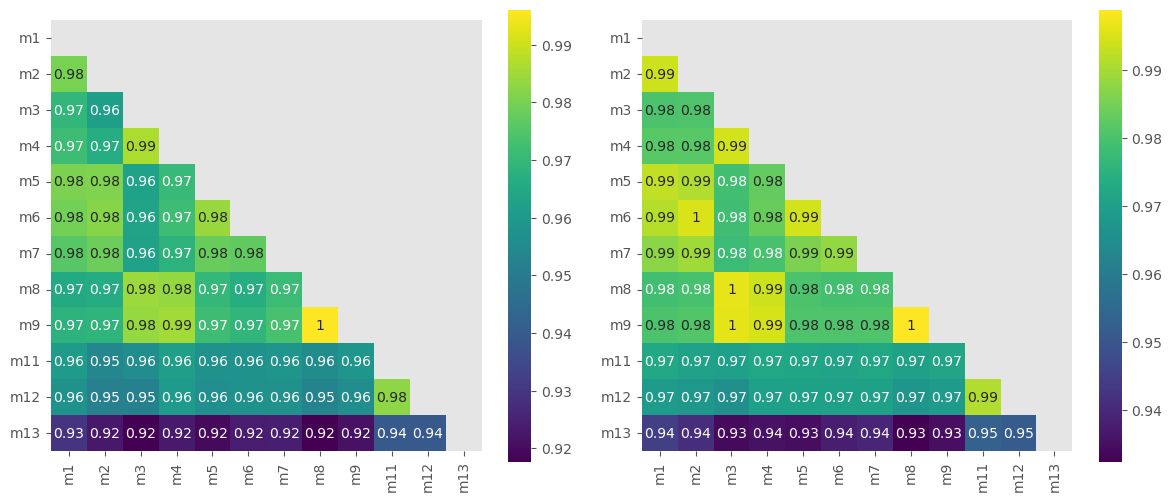

In [123]:
corr = oof_predictions.corr()
corr2 = test_probs.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2g", square=True, cmap="viridis", ax=axes[0])
sns.heatmap(corr2, mask=mask, annot=True, fmt=".2g", square=True, cmap="viridis", ax=axes[1])
plt.tight_layout()
plt.show()

In [124]:
mean_scores(oof_predictions, y)

AMean score: 0.73455
GMean score: 0.73448
Rank  score: 0.73457
GMean  rank: 0.73445


In [60]:
test_preds = test_probs.mean(axis=1)
# 0.73492 (except m10)
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_preds})  # 0.73257 (selected), 0.73352 (blended), 0.73464
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  5%|4         | 232k/4.90M [00:00<00:03, 1.58MB/s]
 39%|###8      | 1.91M/4.90M [00:00<00:00, 3.71MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.35MB/s]


In [72]:
d = oof_predictions.shape[1]
stat_max = np.mean(oof_predictions, axis=1)
roc_max = roc_auc_score(y, stat_max)
while d > 4: 
    for subscores in combinations(oof_predictions.columns, r=d-1):
        stat = np.mean(oof_predictions[list(subscores)], axis=1)
        stat = roc_auc_score(y, stat)
        if stat > roc_max:
            roc_max = stat
            best_sub = list(subscores)
    d-=1
print(best_sub, roc_max)

['m4', 'm8', 'm10', 'm11', 'm12'] 0.7355492860852342


In [43]:
test_preds = test_probs[["m3", "m4", "m8", "m11"]].mean(axis=1)
#  0.73514 on ["m3", "m4", "m8", "m11"] models out of 10 models
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_preds})  # 0.73266 (selected), 0.73403 (blended), 0.73451 (lgb+xgb new)
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.89M [00:00<?, ?B/s]
  4%|4         | 208k/4.89M [00:00<00:03, 1.46MB/s]
 45%|####5     | 2.20M/4.89M [00:00<00:00, 2.94MB/s]
 98%|#########7| 4.78M/4.89M [00:00<00:00, 6.70MB/s]
100%|##########| 4.89M/4.89M [00:02<00:00, 2.18MB/s]


In [125]:
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda,
                                                             X=oof_predictions,
                                                             y=y,
                                                             cv=KFold(n_splits=5, shuffle=True, random_state=seed))

Fold 1, Train score: 0.73230, Valid score = 0.74791
Fold 2, Train score: 0.73607, Valid score = 0.73262
Fold 3, Train score: 0.73499, Valid score = 0.73600
Fold 4, Train score: 0.73505, Valid score = 0.73518
Fold 5, Train score: 0.73764, Valid score = 0.72493
Train score by each fold: [0.7323, 0.73607, 0.73499, 0.73505, 0.73764]
Valid score by each fold: [0.74791, 0.73262, 0.736, 0.73518, 0.72493]
Train mean score by each fold:0.73521 +/- 0.00174
Valid mean score by each fold:0.73533 +/- 0.00741
**************************************************


In [126]:
train_preds = np.array([estimator.predict_proba(oof_predictions)[:,1] for estimator in estimators_lda]).T
train_preds = np.average(train_preds, axis=1)

calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lda, roc_auc_score))

(0.7290663903481712, 0.7395620479348404)

In [119]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_lda]).T
test_fin = pd.DataFrame(data=test_fin)
# 0.73608 - on first 1-9, 11, 12, 13 models!
test_fin = np.average(test_fin, axis=1)  # 0.73248 (selected), 0.73401 (blended), 0.73429 (#5lda, lgbm new), 0.73443 (+xgb)
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.92M [00:00<?, ?B/s]
  4%|4         | 224k/4.92M [00:00<00:03, 1.49MB/s]
 39%|###8      | 1.91M/4.92M [00:00<00:00, 3.70MB/s]
100%|##########| 4.92M/4.92M [00:02<00:00, 2.53MB/s]


#### Categorical

In [20]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]

data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X.shape

Memory usage of dataframe is 187.87 MB
Memory usage after optimization is: 87.74 MB
Decreased by 53.3%


(110093, 99)

In [21]:
X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop([ID_COL, TARGET], axis=1, inplace=True)

In [142]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params_my), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

32 attributes confirmed important: ['EXTERNAL_SCORING_RATING_3', 'NEW_STATUS', 'GENDER', 'EXTERNAL_SCORE_WEIGHTED', 'AGE', 'EXT_SCORES_nanmedian', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'OWN_CAR_AGE', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'RATIO_CREDIT_TO_AGE', 'EXTERNAL_SCORING_PROD', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EXT_SCORE_3_ANNUITY', 'EXT_SCORES_max', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'RATIO_CAR_TO_EXPERIENCE', 'EXT_SCORES_var', 'EXT_SCORES_mean', 'EDUCATION_FAMILY_STATUS', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'RATIO_AGE_TO_EXPERIENCE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'NAME_CONTRACT_TYPE', 'EXT_SCORES_min', 'ANNUITY_JOB', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'RATIO_ANNUITY_TO_AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'RATIO_CAR_TO_AGE']
117 attributes confirmed unimportant: ['BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_AMT_CREDIT_SUM_OVERDUE

In [22]:
boruta = ['EXTERNAL_SCORING_RATING_3', 'NEW_STATUS', 'GENDER', 'EXTERNAL_SCORE_WEIGHTED', 'AGE', 'EXT_SCORES_nanmedian', 
          'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'OWN_CAR_AGE', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'RATIO_CREDIT_TO_AGE', 
          'EXTERNAL_SCORING_PROD', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EXT_SCORE_3_ANNUITY', 'EXT_SCORES_max', 
          'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'RATIO_CAR_TO_EXPERIENCE', 'EXT_SCORES_var', 'EXT_SCORES_mean', 
          'EDUCATION_FAMILY_STATUS', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
          'RATIO_AGE_TO_EXPERIENCE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'NAME_CONTRACT_TYPE', 
          'EXT_SCORES_min', 'ANNUITY_JOB', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 
          'RATIO_ANNUITY_TO_AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'RATIO_CAR_TO_AGE', 'EXT_SCORE_2_AMT_CREDIT', 
          'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'EXT_SCORE_3_AMT_CREDIT', 'AGE_BIN', 'DAYS_ON_LAST_JOB', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMOUNT_CREDIT', 
          'CREDIT_JOB', 'TOTAL_SALARY_MIN_BY_EDUCATION']

In [157]:
start_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 5000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 455,
}


def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 5, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.06),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 155),
                    'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 150)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 X[boruta], 
                                                 y, 
                                                 cv=fold, 
                                                 rounds=100,
                                                 verbose=False)
    
    
    return score

In [158]:
%%time
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=15000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

[I 2022-09-28 01:43:22,474] A new study created in memory with name: no-name-d5930c0e-aade-4ebb-820d-02af8756c336
[I 2022-09-28 01:43:29,033] Trial 0 finished with value: 0.730802 and parameters: {'max_depth': 7, 'learning_rate': 0.05706750123139001, 'num_leaves': 115, 'min_child_samples': 188, 'min_child_weight': 23.403640047725037}. Best is trial 0 with value: 0.730802.
[I 2022-09-28 01:43:53,352] Trial 1 finished with value: 0.723706 and parameters: {'max_depth': 6, 'learning_rate': 0.003955974924007868, 'num_leaves': 135, 'min_child_samples': 188, 'min_child_weight': 106.21117859682903}. Best is trial 0 with value: 0.730802.
[I 2022-09-28 01:43:59,742] Trial 2 finished with value: 0.7308020000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.05820963620363866, 'num_leaves': 130, 'min_child_samples': 79, 'min_child_weight': 27.274563256097885}. Best is trial 2 with value: 0.7308020000000001.
[I 2022-09-28 01:44:14,077] Trial 3 finished with value: 0.7310639999999999 and par

[I 2022-09-28 01:49:18,682] Trial 29 finished with value: 0.7287000000000001 and parameters: {'max_depth': 7, 'learning_rate': 0.04021106416989896, 'num_leaves': 109, 'min_child_samples': 221, 'min_child_weight': 16.97361401546234}. Best is trial 3 with value: 0.7310639999999999.
[I 2022-09-28 01:49:25,868] Trial 30 finished with value: 0.7296 and parameters: {'max_depth': 6, 'learning_rate': 0.05492846333707085, 'num_leaves': 94, 'min_child_samples': 118, 'min_child_weight': 21.2040111165149}. Best is trial 3 with value: 0.7310639999999999.
[I 2022-09-28 01:49:34,419] Trial 31 finished with value: 0.730406 and parameters: {'max_depth': 5, 'learning_rate': 0.05877029726881813, 'num_leaves': 132, 'min_child_samples': 82, 'min_child_weight': 34.81779076421323}. Best is trial 3 with value: 0.7310639999999999.
[I 2022-09-28 01:49:42,155] Trial 32 finished with value: 0.730408 and parameters: {'max_depth': 5, 'learning_rate': 0.05937294470416084, 'num_leaves': 128, 'min_child_samples': 73, 

[I 2022-09-28 01:54:36,067] Trial 58 finished with value: 0.729462 and parameters: {'max_depth': 5, 'learning_rate': 0.008517742675935774, 'num_leaves': 155, 'min_child_samples': 175, 'min_child_weight': 60.29016266651688}. Best is trial 3 with value: 0.7310639999999999.
[I 2022-09-28 01:54:45,441] Trial 59 finished with value: 0.729056 and parameters: {'max_depth': 6, 'learning_rate': 0.04450685723834427, 'num_leaves': 104, 'min_child_samples': 76, 'min_child_weight': 10.465672559923876}. Best is trial 3 with value: 0.7310639999999999.
[I 2022-09-28 01:54:54,179] Trial 60 finished with value: 0.7284180000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.05490158029638051, 'num_leaves': 97, 'min_child_samples': 135, 'min_child_weight': 28.158276363389753}. Best is trial 3 with value: 0.7310639999999999.
[I 2022-09-28 01:55:00,836] Trial 61 finished with value: 0.729846 and parameters: {'max_depth': 6, 'learning_rate': 0.05791160418448703, 'num_leaves': 141, 'min_child_samples

[I 2022-09-28 02:01:25,225] Trial 87 finished with value: 0.7310800000000001 and parameters: {'max_depth': 8, 'learning_rate': 0.01424378349515502, 'num_leaves': 27, 'min_child_samples': 24, 'min_child_weight': 53.68040389106555}. Best is trial 77 with value: 0.7314320000000001.
[I 2022-09-28 02:01:44,955] Trial 88 finished with value: 0.7307239999999999 and parameters: {'max_depth': 8, 'learning_rate': 0.014293920813409895, 'num_leaves': 43, 'min_child_samples': 22, 'min_child_weight': 53.262761591343114}. Best is trial 77 with value: 0.7314320000000001.
[I 2022-09-28 02:02:06,615] Trial 89 finished with value: 0.730536 and parameters: {'max_depth': 9, 'learning_rate': 0.009627582735656781, 'num_leaves': 27, 'min_child_samples': 41, 'min_child_weight': 62.4475992389682}. Best is trial 77 with value: 0.7314320000000001.
[I 2022-09-28 02:02:19,437] Trial 90 finished with value: 0.7301639999999999 and parameters: {'max_depth': 9, 'learning_rate': 0.025215592977808066, 'num_leaves': 8, 'm

[I 2022-09-28 02:09:16,774] Trial 116 finished with value: 0.73058 and parameters: {'max_depth': 9, 'learning_rate': 0.024492277485487657, 'num_leaves': 30, 'min_child_samples': 56, 'min_child_weight': 45.67698676277135}. Best is trial 115 with value: 0.73145.
[I 2022-09-28 02:09:33,083] Trial 117 finished with value: 0.731008 and parameters: {'max_depth': 10, 'learning_rate': 0.019623224960074657, 'num_leaves': 9, 'min_child_samples': 68, 'min_child_weight': 48.64652791594635}. Best is trial 115 with value: 0.73145.
[I 2022-09-28 02:09:51,576] Trial 118 finished with value: 0.7304480000000001 and parameters: {'max_depth': 10, 'learning_rate': 0.015482396332150677, 'num_leaves': 13, 'min_child_samples': 39, 'min_child_weight': 58.75903664454962}. Best is trial 115 with value: 0.73145.
[I 2022-09-28 02:10:04,021] Trial 119 finished with value: 0.730664 and parameters: {'max_depth': 9, 'learning_rate': 0.02284006405556849, 'num_leaves': 34, 'min_child_samples': 26, 'min_child_weight': 43

[I 2022-09-28 02:16:41,574] Trial 145 finished with value: 0.731434 and parameters: {'max_depth': 8, 'learning_rate': 0.014211288098152789, 'num_leaves': 22, 'min_child_samples': 47, 'min_child_weight': 28.560085277477818}. Best is trial 127 with value: 0.7316480000000001.
[I 2022-09-28 02:16:59,935] Trial 146 finished with value: 0.7309340000000001 and parameters: {'max_depth': 8, 'learning_rate': 0.01433891357413333, 'num_leaves': 23, 'min_child_samples': 48, 'min_child_weight': 25.200008123325258}. Best is trial 127 with value: 0.7316480000000001.
[I 2022-09-28 02:17:21,029] Trial 147 finished with value: 0.7313099999999999 and parameters: {'max_depth': 8, 'learning_rate': 0.012927671574574268, 'num_leaves': 26, 'min_child_samples': 24, 'min_child_weight': 29.460999874744818}. Best is trial 127 with value: 0.7316480000000001.
[I 2022-09-28 02:17:45,405] Trial 148 finished with value: 0.730866 and parameters: {'max_depth': 8, 'learning_rate': 0.01210300196089422, 'num_leaves': 14, 'm

[I 2022-09-28 02:25:31,437] Trial 174 finished with value: 0.731368 and parameters: {'max_depth': 8, 'learning_rate': 0.009967580370497761, 'num_leaves': 26, 'min_child_samples': 27, 'min_child_weight': 32.88241276387555}. Best is trial 127 with value: 0.7316480000000001.
[I 2022-09-28 02:25:58,276] Trial 175 finished with value: 0.731028 and parameters: {'max_depth': 8, 'learning_rate': 0.0097799805062054, 'num_leaves': 33, 'min_child_samples': 32, 'min_child_weight': 32.87212753989147}. Best is trial 127 with value: 0.7316480000000001.
[I 2022-09-28 02:26:15,489] Trial 176 finished with value: 0.731544 and parameters: {'max_depth': 8, 'learning_rate': 0.017463774679032613, 'num_leaves': 25, 'min_child_samples': 27, 'min_child_weight': 33.75563611686491}. Best is trial 127 with value: 0.7316480000000001.
[I 2022-09-28 02:26:31,571] Trial 177 finished with value: 0.7311920000000001 and parameters: {'max_depth': 8, 'learning_rate': 0.016125523148788647, 'num_leaves': 28, 'min_child_samp

[I 2022-09-28 02:33:40,498] Trial 203 finished with value: 0.7309840000000001 and parameters: {'max_depth': 9, 'learning_rate': 0.016544908430258968, 'num_leaves': 24, 'min_child_samples': 37, 'min_child_weight': 31.831483331801902}. Best is trial 185 with value: 0.73171.
[I 2022-09-28 02:33:57,164] Trial 204 finished with value: 0.731218 and parameters: {'max_depth': 8, 'learning_rate': 0.01901101032441562, 'num_leaves': 32, 'min_child_samples': 58, 'min_child_weight': 28.766198338574615}. Best is trial 185 with value: 0.73171.
[I 2022-09-28 02:34:11,319] Trial 205 finished with value: 0.73131 and parameters: {'max_depth': 8, 'learning_rate': 0.019810699727900186, 'num_leaves': 28, 'min_child_samples': 41, 'min_child_weight': 26.978182036763954}. Best is trial 185 with value: 0.73171.
[I 2022-09-28 02:34:26,699] Trial 206 finished with value: 0.73137 and parameters: {'max_depth': 7, 'learning_rate': 0.02200053148627834, 'num_leaves': 20, 'min_child_samples': 25, 'min_child_weight': 23

[I 2022-09-28 02:41:23,864] Trial 233 finished with value: 0.731228 and parameters: {'max_depth': 10, 'learning_rate': 0.015805133977575783, 'num_leaves': 23, 'min_child_samples': 31, 'min_child_weight': 24.825406283462723}. Best is trial 223 with value: 0.731794.
[I 2022-09-28 02:41:41,144] Trial 234 finished with value: 0.7312099999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.014126735768932686, 'num_leaves': 27, 'min_child_samples': 213, 'min_child_weight': 28.791605926715942}. Best is trial 223 with value: 0.731794.
[I 2022-09-28 02:41:54,782] Trial 235 finished with value: 0.7307840000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.017435028504538312, 'num_leaves': 19, 'min_child_samples': 40, 'min_child_weight': 23.16243928965549}. Best is trial 223 with value: 0.731794.
[I 2022-09-28 02:42:10,408] Trial 236 finished with value: 0.730976 and parameters: {'max_depth': 11, 'learning_rate': 0.014979406082295543, 'num_leaves': 29, 'min_child_samples': 35, '

[I 2022-09-28 02:53:06,461] Trial 263 finished with value: 0.7314 and parameters: {'max_depth': 12, 'learning_rate': 0.008338267578600483, 'num_leaves': 33, 'min_child_samples': 60, 'min_child_weight': 33.39581103923703}. Best is trial 259 with value: 0.731798.
[I 2022-09-28 02:53:28,232] Trial 264 finished with value: 0.7312719999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.010582446094069465, 'num_leaves': 25, 'min_child_samples': 44, 'min_child_weight': 30.997439149481405}. Best is trial 259 with value: 0.731798.
[I 2022-09-28 02:53:46,663] Trial 265 finished with value: 0.73132 and parameters: {'max_depth': 12, 'learning_rate': 0.012828312647411712, 'num_leaves': 30, 'min_child_samples': 30, 'min_child_weight': 41.465561502361076}. Best is trial 259 with value: 0.731798.
[I 2022-09-28 02:54:16,216] Trial 266 finished with value: 0.7288439999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.006668152554735481, 'num_leaves': 23, 'min_child_samples': 38, 'min_

[I 2022-09-28 03:04:14,962] Trial 293 finished with value: 0.72611 and parameters: {'max_depth': 10, 'learning_rate': 0.0074649548998674065, 'num_leaves': 41, 'min_child_samples': 195, 'min_child_weight': 72.17169441684402}. Best is trial 259 with value: 0.731798.
[I 2022-09-28 03:04:33,858] Trial 294 finished with value: 0.73185 and parameters: {'max_depth': 10, 'learning_rate': 0.013387357804395992, 'num_leaves': 31, 'min_child_samples': 56, 'min_child_weight': 30.68052791206382}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:04:53,425] Trial 295 finished with value: 0.73077 and parameters: {'max_depth': 10, 'learning_rate': 0.012390151190788994, 'num_leaves': 37, 'min_child_samples': 71, 'min_child_weight': 2.8061512414562912}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:05:10,815] Trial 296 finished with value: 0.7311400000000001 and parameters: {'max_depth': 10, 'learning_rate': 0.013797017872901133, 'num_leaves': 32, 'min_child_samples': 79, 'min_child_weigh

[I 2022-09-28 03:15:46,753] Trial 323 finished with value: 0.731332 and parameters: {'max_depth': 11, 'learning_rate': 0.011732024999159405, 'num_leaves': 39, 'min_child_samples': 46, 'min_child_weight': 25.786931626165853}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:16:10,435] Trial 324 finished with value: 0.726136 and parameters: {'max_depth': 11, 'learning_rate': 0.00602528027554986, 'num_leaves': 30, 'min_child_samples': 34, 'min_child_weight': 39.19489074658786}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:16:32,286] Trial 325 finished with value: 0.7309 and parameters: {'max_depth': 11, 'learning_rate': 0.009312818293964775, 'num_leaves': 32, 'min_child_samples': 40, 'min_child_weight': 34.131566770150485}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:16:57,150] Trial 326 finished with value: 0.731176 and parameters: {'max_depth': 12, 'learning_rate': 0.007919962237457286, 'num_leaves': 28, 'min_child_samples': 48, 'min_child_weight': 26.85920

[I 2022-09-28 03:27:21,146] Trial 353 finished with value: 0.726802 and parameters: {'max_depth': 12, 'learning_rate': 0.007693055033612034, 'num_leaves': 84, 'min_child_samples': 30, 'min_child_weight': 34.778544070958446}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:27:45,442] Trial 354 finished with value: 0.7315180000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.011147529766415438, 'num_leaves': 30, 'min_child_samples': 50, 'min_child_weight': 25.52608855921492}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:28:10,531] Trial 355 finished with value: 0.7312179999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.010371210063145911, 'num_leaves': 29, 'min_child_samples': 39, 'min_child_weight': 19.26524326688903}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:28:35,507] Trial 356 finished with value: 0.731234 and parameters: {'max_depth': 11, 'learning_rate': 0.009267744251791941, 'num_leaves': 25, 'min_child_samples': 49, 'min_c

[I 2022-09-28 03:37:58,995] Trial 383 finished with value: 0.7293200000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.01673418575791556, 'num_leaves': 32, 'min_child_samples': 20, 'min_child_weight': 139.5209693499794}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:38:14,641] Trial 384 finished with value: 0.730788 and parameters: {'max_depth': 11, 'learning_rate': 0.014838171056161443, 'num_leaves': 35, 'min_child_samples': 38, 'min_child_weight': 16.89032848130154}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:38:28,146] Trial 385 finished with value: 0.731332 and parameters: {'max_depth': 12, 'learning_rate': 0.017819797002018457, 'num_leaves': 31, 'min_child_samples': 34, 'min_child_weight': 26.743997332341046}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:38:43,731] Trial 386 finished with value: 0.73126 and parameters: {'max_depth': 8, 'learning_rate': 0.015494638124482646, 'num_leaves': 28, 'min_child_samples': 44, 'min_child_weight':

[I 2022-09-28 03:47:01,272] Trial 413 finished with value: 0.726494 and parameters: {'max_depth': 12, 'learning_rate': 0.005085367166184726, 'num_leaves': 36, 'min_child_samples': 37, 'min_child_weight': 35.10528115538991}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:47:16,345] Trial 414 finished with value: 0.731048 and parameters: {'max_depth': 8, 'learning_rate': 0.018158188851240487, 'num_leaves': 28, 'min_child_samples': 28, 'min_child_weight': 18.96504582757509}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:47:28,627] Trial 415 finished with value: 0.730586 and parameters: {'max_depth': 11, 'learning_rate': 0.02077808859157754, 'num_leaves': 17, 'min_child_samples': 34, 'min_child_weight': 41.36003576991414}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:47:53,941] Trial 416 finished with value: 0.730794 and parameters: {'max_depth': 8, 'learning_rate': 0.007387519938041914, 'num_leaves': 23, 'min_child_samples': 25, 'min_child_weight': 21.5692535

[I 2022-09-28 03:56:17,872] Trial 443 finished with value: 0.7310519999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.015504076975237122, 'num_leaves': 21, 'min_child_samples': 36, 'min_child_weight': 31.767898920458286}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:56:34,905] Trial 444 finished with value: 0.731046 and parameters: {'max_depth': 11, 'learning_rate': 0.014183673017041036, 'num_leaves': 30, 'min_child_samples': 126, 'min_child_weight': 28.478277504920726}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:56:53,122] Trial 445 finished with value: 0.730534 and parameters: {'max_depth': 11, 'learning_rate': 0.014788978678128917, 'num_leaves': 57, 'min_child_samples': 42, 'min_child_weight': 36.0769909533508}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 03:57:09,269] Trial 446 finished with value: 0.7308739999999999 and parameters: {'max_depth': 11, 'learning_rate': 0.013171457221419975, 'num_leaves': 23, 'min_child_samples': 47, 'min_

[I 2022-09-28 04:05:09,545] Trial 473 finished with value: 0.73087 and parameters: {'max_depth': 11, 'learning_rate': 0.01035056863444479, 'num_leaves': 21, 'min_child_samples': 33, 'min_child_weight': 27.73874522755366}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:05:19,885] Trial 474 finished with value: 0.7306520000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.023538710433769927, 'num_leaves': 29, 'min_child_samples': 26, 'min_child_weight': 19.499387601677785}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:05:38,389] Trial 475 finished with value: 0.73126 and parameters: {'max_depth': 12, 'learning_rate': 0.011757533707204214, 'num_leaves': 25, 'min_child_samples': 33, 'min_child_weight': 32.2460670885995}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:05:52,878] Trial 476 finished with value: 0.731172 and parameters: {'max_depth': 11, 'learning_rate': 0.01678350402579733, 'num_leaves': 27, 'min_child_samples': 224, 'min_child_weight': 

[I 2022-09-28 04:14:20,933] Trial 503 finished with value: 0.731348 and parameters: {'max_depth': 11, 'learning_rate': 0.016542753331122245, 'num_leaves': 34, 'min_child_samples': 43, 'min_child_weight': 25.583840996184826}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:14:40,313] Trial 504 finished with value: 0.7313240000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.012980889959658749, 'num_leaves': 23, 'min_child_samples': 32, 'min_child_weight': 29.620034382047088}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:15:08,931] Trial 505 finished with value: 0.730016 and parameters: {'max_depth': 12, 'learning_rate': 0.005936131835816997, 'num_leaves': 17, 'min_child_samples': 29, 'min_child_weight': 36.34884182583553}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:15:38,301] Trial 506 finished with value: 0.729766 and parameters: {'max_depth': 11, 'learning_rate': 0.008465942132269191, 'num_leaves': 79, 'min_child_samples': 37, 'min_child_weig

[I 2022-09-28 04:25:20,227] Trial 533 finished with value: 0.731026 and parameters: {'max_depth': 12, 'learning_rate': 0.011113572418970645, 'num_leaves': 27, 'min_child_samples': 35, 'min_child_weight': 64.62636111799338}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:25:37,832] Trial 534 finished with value: 0.729826 and parameters: {'max_depth': 11, 'learning_rate': 0.012273220231820457, 'num_leaves': 25, 'min_child_samples': 43, 'min_child_weight': 107.86018643781146}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:26:04,219] Trial 535 finished with value: 0.731552 and parameters: {'max_depth': 11, 'learning_rate': 0.0077999013704165635, 'num_leaves': 29, 'min_child_samples': 26, 'min_child_weight': 32.412914585216924}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:26:26,016] Trial 536 finished with value: 0.7309499999999999 and parameters: {'max_depth': 8, 'learning_rate': 0.009908854861940108, 'num_leaves': 21, 'min_child_samples': 36, 'min_child_weig

[I 2022-09-28 04:35:48,869] Trial 563 finished with value: 0.7311620000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.01144179050139653, 'num_leaves': 28, 'min_child_samples': 22, 'min_child_weight': 45.31654832376606}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:36:04,502] Trial 564 finished with value: 0.7307600000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.011955879854209924, 'num_leaves': 23, 'min_child_samples': 24, 'min_child_weight': 38.42004260451739}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:36:23,719] Trial 565 finished with value: 0.731224 and parameters: {'max_depth': 12, 'learning_rate': 0.013313310048583516, 'num_leaves': 30, 'min_child_samples': 28, 'min_child_weight': 35.92919445685259}. Best is trial 294 with value: 0.73185.
[I 2022-09-28 04:36:43,134] Trial 566 finished with value: 0.73133 and parameters: {'max_depth': 12, 'learning_rate': 0.011603925116774038, 'num_leaves': 26, 'min_child_samples': 31, 'min_chil

[I 2022-09-28 04:44:41,281] Trial 593 finished with value: 0.730696 and parameters: {'max_depth': 12, 'learning_rate': 0.0216459977629826, 'num_leaves': 20, 'min_child_samples': 30, 'min_child_weight': 34.09336870507683}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 04:44:54,024] Trial 594 finished with value: 0.7310899999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.0224625169523489, 'num_leaves': 17, 'min_child_samples': 35, 'min_child_weight': 28.229328747355655}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 04:45:08,165] Trial 595 finished with value: 0.7311460000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.020845306680044983, 'num_leaves': 21, 'min_child_samples': 29, 'min_child_weight': 24.53879156030408}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 04:45:22,357] Trial 596 finished with value: 0.7306100000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.019507588187714184, 'num_leave

[I 2022-09-28 04:51:56,610] Trial 622 finished with value: 0.731266 and parameters: {'max_depth': 12, 'learning_rate': 0.0135715909613776, 'num_leaves': 24, 'min_child_samples': 242, 'min_child_weight': 32.32743832589033}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 04:52:19,986] Trial 623 finished with value: 0.7308100000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.01118919531509411, 'num_leaves': 18, 'min_child_samples': 37, 'min_child_weight': 21.62729441934613}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 04:52:35,780] Trial 624 finished with value: 0.7305820000000001 and parameters: {'max_depth': 8, 'learning_rate': 0.01670549166576858, 'num_leaves': 28, 'min_child_samples': 33, 'min_child_weight': 11.280230031164269}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 04:53:02,506] Trial 625 finished with value: 0.731282 and parameters: {'max_depth': 12, 'learning_rate': 0.009464700398800851, 'num_leaves': 31, 'm

[I 2022-09-28 05:00:58,679] Trial 651 finished with value: 0.7295780000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.009674264635694155, 'num_leaves': 13, 'min_child_samples': 29, 'min_child_weight': 21.75101894976806}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:01:25,303] Trial 652 finished with value: 0.731472 and parameters: {'max_depth': 12, 'learning_rate': 0.007805420294868854, 'num_leaves': 25, 'min_child_samples': 46, 'min_child_weight': 29.255580304578295}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:01:47,373] Trial 653 finished with value: 0.731304 and parameters: {'max_depth': 11, 'learning_rate': 0.011256701004152457, 'num_leaves': 31, 'min_child_samples': 34, 'min_child_weight': 25.402766734147477}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:02:02,227] Trial 654 finished with value: 0.7308199999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.01923942748186037, 'num_leaves': 20

[I 2022-09-28 05:10:38,191] Trial 680 finished with value: 0.7314320000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.013897016131378991, 'num_leaves': 32, 'min_child_samples': 43, 'min_child_weight': 31.458409811716127}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:11:03,200] Trial 681 finished with value: 0.7308779999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.009525088317090522, 'num_leaves': 17, 'min_child_samples': 58, 'min_child_weight': 28.43634325576681}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:11:32,003] Trial 682 finished with value: 0.7312480000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.00670717503371149, 'num_leaves': 26, 'min_child_samples': 35, 'min_child_weight': 34.48287119484397}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:11:50,859] Trial 683 finished with value: 0.731468 and parameters: {'max_depth': 11, 'learning_rate': 0.01218135682567283, 'num_lea

[I 2022-09-28 05:20:29,645] Trial 709 finished with value: 0.731522 and parameters: {'max_depth': 11, 'learning_rate': 0.01405145032962396, 'num_leaves': 24, 'min_child_samples': 25, 'min_child_weight': 39.045903052055685}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:20:48,630] Trial 710 finished with value: 0.7297300000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.010056671769747302, 'num_leaves': 15, 'min_child_samples': 128, 'min_child_weight': 90.81811929797598}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:21:09,763] Trial 711 finished with value: 0.7311219999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.0108565614636243, 'num_leaves': 20, 'min_child_samples': 35, 'min_child_weight': 24.719533197495355}. Best is trial 591 with value: 0.7318659999999999.
[I 2022-09-28 05:21:28,330] Trial 712 finished with value: 0.731574 and parameters: {'max_depth': 10, 'learning_rate': 0.012666206425010557, 'num_leaves': 31,

[I 2022-09-28 05:31:06,221] Trial 738 finished with value: 0.7316040000000001 and parameters: {'max_depth': 11, 'learning_rate': 0.01172071093419972, 'num_leaves': 33, 'min_child_samples': 34, 'min_child_weight': 30.572411094108276}. Best is trial 721 with value: 0.73194.
[I 2022-09-28 05:31:32,521] Trial 739 finished with value: 0.7312200000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.007410628671011714, 'num_leaves': 30, 'min_child_samples': 42, 'min_child_weight': 29.35369052624673}. Best is trial 721 with value: 0.73194.
[I 2022-09-28 05:31:51,753] Trial 740 finished with value: 0.731454 and parameters: {'max_depth': 11, 'learning_rate': 0.013117941011708226, 'num_leaves': 25, 'min_child_samples': 25, 'min_child_weight': 34.45442076925345}. Best is trial 721 with value: 0.73194.
[I 2022-09-28 05:32:10,750] Trial 741 finished with value: 0.731196 and parameters: {'max_depth': 11, 'learning_rate': 0.010776568284325341, 'num_leaves': 27, 'min_child_samples': 30, 'min_ch

[I 2022-09-28 05:40:34,831] Trial 768 finished with value: 0.731056 and parameters: {'max_depth': 11, 'learning_rate': 0.012351424104337351, 'num_leaves': 25, 'min_child_samples': 240, 'min_child_weight': 36.23167178452009}. Best is trial 721 with value: 0.73194.
[I 2022-09-28 05:40:51,360] Trial 769 finished with value: 0.7296020000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.017557015726534782, 'num_leaves': 97, 'min_child_samples': 294, 'min_child_weight': 33.34781241009674}. Best is trial 721 with value: 0.73194.
[I 2022-09-28 05:41:06,529] Trial 770 finished with value: 0.731386 and parameters: {'max_depth': 11, 'learning_rate': 0.01680114689124069, 'num_leaves': 27, 'min_child_samples': 35, 'min_child_weight': 38.4404022614971}. Best is trial 721 with value: 0.73194.
[I 2022-09-28 05:41:22,915] Trial 771 finished with value: 0.73131 and parameters: {'max_depth': 11, 'learning_rate': 0.01577995874159229, 'num_leaves': 29, 'min_child_samples': 28, 'min_child_weight':

[I 2022-09-28 05:49:34,407] Trial 798 finished with value: 0.731114 and parameters: {'max_depth': 12, 'learning_rate': 0.011710532300206928, 'num_leaves': 32, 'min_child_samples': 25, 'min_child_weight': 24.922246489160642}. Best is trial 787 with value: 0.732072.
[I 2022-09-28 05:49:49,832] Trial 799 finished with value: 0.7315280000000001 and parameters: {'max_depth': 12, 'learning_rate': 0.016997061324666864, 'num_leaves': 29, 'min_child_samples': 20, 'min_child_weight': 28.85562746351317}. Best is trial 787 with value: 0.732072.
[I 2022-09-28 05:50:10,774] Trial 800 finished with value: 0.7293379999999999 and parameters: {'max_depth': 12, 'learning_rate': 0.013225907648550427, 'num_leaves': 144, 'min_child_samples': 26, 'min_child_weight': 33.80329227777411}. Best is trial 787 with value: 0.732072.
[I 2022-09-28 05:50:31,079] Trial 801 finished with value: 0.731166 and parameters: {'max_depth': 12, 'learning_rate': 0.0117077942593571, 'num_leaves': 41, 'min_child_samples': 28, 'min

Number of completed trials: 813
Best trial
Best score: 0.732072
Best params
{'learning_rate': 0.012296084696004845,
 'max_depth': 11,
 'min_child_samples': 25,
 'min_child_weight': 31.645731702081406,
 'num_leaves': 28}
CPU times: total: 2d 16h 52min 29s
Wall time: 4h 10min 19s


In [23]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 5000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 455,
                'learning_rate': 0.012296084696004845,
                'max_depth': 11,
                'min_child_samples': 25,
                'min_child_weight': 31.645731702081406,
                'num_leaves': 28
}

estimators_lgbm_c, oof_cat_lgbm = lightgbm_cross_validation(tunned_params, 
                                                            X[boruta], 
                                                            y, 
                                                            cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                            rounds=100)
gc.collect()  # 73049

Sat Oct  1 11:32:26 2022, Cross-Validation, 110093 rows, 43 cols
Fold 1, Train score = 0.76724, Valid score = 0.74620
Fold 2, Train score = 0.78804, Valid score = 0.73077
Fold 3, Train score = 0.77630, Valid score = 0.72749
Fold 4, Train score = 0.77622, Valid score = 0.73645
Fold 5, Train score = 0.78968, Valid score = 0.73234
Fold 6, Train score = 0.78355, Valid score = 0.72364
Fold 7, Train score = 0.78044, Valid score = 0.72417
Train score by each fold: [0.76724, 0.78804, 0.7763, 0.77622, 0.78968, 0.78355, 0.78044]
Valid score by each fold: [0.7462, 0.73077, 0.72749, 0.73645, 0.73234, 0.72364, 0.72417]
Train mean score by each fold:0.78021 +/- 0.00719
Valid mean score by each fold:0.73158 +/- 0.00730
**************************************************
OOF-score: 0.73049


167

In [24]:
test_preds7 = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_lgbm_c]).T.mean(axis=1)

In [25]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 5000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 455,
                'learning_rate': 0.012296084696004845,
                'max_depth': 11,
                'min_child_samples': 25,
                'min_child_weight': 31.645731702081406,
                'num_leaves': 28
}

estimators_lgbm_c2, oof_cat_lgbm2 = lightgbm_cross_validation(tunned_params, 
                                                              X[ex_overall], 
                                                              y, 
                                                              cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                              rounds=100)
gc.collect()  # 73363

Sat Oct  1 11:33:02 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.77082, Valid score = 0.74994
Fold 2, Train score = 0.78322, Valid score = 0.73714
Fold 3, Train score = 0.77742, Valid score = 0.72881
Fold 4, Train score = 0.79060, Valid score = 0.73889
Fold 5, Train score = 0.80273, Valid score = 0.73474
Fold 6, Train score = 0.79813, Valid score = 0.72474
Fold 7, Train score = 0.78575, Valid score = 0.72627
Train score by each fold: [0.77082, 0.78322, 0.77742, 0.7906, 0.80273, 0.79813, 0.78575]
Valid score by each fold: [0.74994, 0.73714, 0.72881, 0.73889, 0.73474, 0.72474, 0.72627]
Train mean score by each fold:0.78695 +/- 0.01038
Valid mean score by each fold:0.73436 +/- 0.00811
**************************************************
OOF-score: 0.73363


768

In [26]:
test_preds8 = np.array([model.predict_proba(data_test[ex_overall])[:,1] for model in estimators_lgbm_c2]).T.mean(axis=1)

In [27]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 5000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 455,
                'learning_rate': 0.012296084696004845,
                'max_depth': 8,
                'min_child_samples': 25,
                'min_child_weight': 31.645731702081406,
                'num_leaves': 28
}

estimators_lgbm_c3, oof_cat_lgbm3 = lightgbm_cross_validation(tunned_params, 
                                                              X[ex_overall], 
                                                              y, 
                                                              cv=KFold(n_splits=7, random_state=seed, shuffle=True), 
                                                              rounds=100)
gc.collect()  # 73341

Sat Oct  1 11:33:43 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.77228, Valid score = 0.75036
Fold 2, Train score = 0.77877, Valid score = 0.73667
Fold 3, Train score = 0.77936, Valid score = 0.72945
Fold 4, Train score = 0.78196, Valid score = 0.73904
Fold 5, Train score = 0.77716, Valid score = 0.73270
Fold 6, Train score = 0.78592, Valid score = 0.72467
Fold 7, Train score = 0.78502, Valid score = 0.72565
Train score by each fold: [0.77228, 0.77877, 0.77936, 0.78196, 0.77716, 0.78592, 0.78502]
Valid score by each fold: [0.75036, 0.73667, 0.72945, 0.73904, 0.7327, 0.72467, 0.72565]
Train mean score by each fold:0.78007 +/- 0.00437
Valid mean score by each fold:0.73408 +/- 0.00827
**************************************************
OOF-score: 0.73341


66

In [28]:
test_preds9 = np.array([model.predict_proba(data_test[ex_overall])[:,1] for model in estimators_lgbm_c3]).T.mean(axis=1)

### Tune XGBoost

In [200]:
# label+ohe
start_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1
}

def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 5, 12),
                    'eta': trial.suggest_float('eta', 0.001, 0.1),
                    'gamma': trial.suggest_float('gamma', 0, 25),
                    'min_child_weight': trial.suggest_int('min_child_weight', 2, 300)
                    }

    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)

    _, _, _, score = xgboost_cross_validation(param_trials, 
                                              X[exhaust], 
                                              y, 
                                              cv=fold, 
                                              rounds=100,
                                              verbose=False,
                                              return_valid_mean=True)


    return score

optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=15000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

[I 2022-09-28 09:48:49,715] A new study created in memory with name: no-name-0727d07e-6ec2-41ac-97cb-43037007026d
[I 2022-09-28 09:50:56,551] Trial 0 finished with value: 0.7254400000000001 and parameters: {'max_depth': 7, 'eta': 0.0951207163345817, 'gamma': 18.299848545285126, 'min_child_weight': 180}. Best is trial 0 with value: 0.7254400000000001.
[I 2022-09-28 09:55:29,409] Trial 1 finished with value: 0.72814 and parameters: {'max_depth': 6, 'eta': 0.016443457513284063, 'gamma': 1.4520903042049866, 'min_child_weight': 260}. Best is trial 1 with value: 0.72814.
[I 2022-09-28 09:57:06,174] Trial 2 finished with value: 0.727398 and parameters: {'max_depth': 9, 'eta': 0.07109918520180851, 'gamma': 0.5146123573950612, 'min_child_weight': 292}. Best is trial 1 with value: 0.72814.
[I 2022-09-28 10:01:05,045] Trial 3 finished with value: 0.7285920000000001 and parameters: {'max_depth': 11, 'eta': 0.022021571957149343, 'gamma': 4.545624180177516, 'min_child_weight': 56}. Best is trial 3 w

[I 2022-09-28 12:07:58,756] Trial 34 finished with value: 0.730774 and parameters: {'max_depth': 6, 'eta': 0.04901450422616065, 'gamma': 11.902792936864168, 'min_child_weight': 2}. Best is trial 20 with value: 0.73144.
[I 2022-09-28 12:10:40,896] Trial 35 finished with value: 0.727168 and parameters: {'max_depth': 5, 'eta': 0.06412491332887096, 'gamma': 16.119001409084092, 'min_child_weight': 72}. Best is trial 20 with value: 0.73144.
[I 2022-09-28 12:13:19,728] Trial 36 finished with value: 0.7306459999999999 and parameters: {'max_depth': 7, 'eta': 0.07330882453768456, 'gamma': 10.83058593330017, 'min_child_weight': 44}. Best is trial 20 with value: 0.73144.
[I 2022-09-28 12:14:54,690] Trial 37 finished with value: 0.7273 and parameters: {'max_depth': 6, 'eta': 0.08300592043601981, 'gamma': 4.051713236841186, 'min_child_weight': 297}. Best is trial 20 with value: 0.73144.
[I 2022-09-28 12:18:56,691] Trial 38 finished with value: 0.729542 and parameters: {'max_depth': 8, 'eta': 0.05171

Number of completed trials: 62
Best trial
Best score: 0.7318020000000001
Best params
{'eta': 0.06028932903405389,
 'gamma': 13.784827199638096,
 'max_depth': 12,
 'min_child_weight': 30}


#### Next model

In [29]:
def create_client_profile_features(data: pd.DataFrame) -> pd.DataFrame:
    X = pd.read_csv("client_profile.csv")

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
    X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)

    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["EXTERNAL_SCORING_WEIGHTED"] = X.EXTERNAL_SCORING_RATING_1 * 2 + X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    X['RATIO_CREDIT_TO_ANNUITY'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["RATIO_ANNUITY_TO_SALARY"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['RATIO_CREDIT_TO_SALARY'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

    X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
    X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]
    
    data = data.merge(X, on=ID_COL, how="left")
    data.replace([-np.inf, np.inf], np.nan, inplace=True)

    return data

In [30]:
data = pd.concat([train, test], axis=0)
data = create_client_profile_features(data)

df_cat_cols = [column for column in data.columns if data[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    if data[col].nunique() < 30:
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col].astype(str).fillna("NA"))

data_border = len(data) - data[TARGET].isna().sum()
data_train, data_test = data.iloc[:data_border, :], data.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X.shape

(110093, 54)

In [31]:
X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [32]:
data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop([ID_COL, TARGET], axis=1, inplace=True)

In [296]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
gc.collect()

0

In [297]:
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:13<00:00,  8.27it/s]


In [299]:
perm2 = deltas[deltas > 0].index.tolist()

In [302]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params_my), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

24 attributes confirmed important: ['EXTERNAL_SCORING_RATING_3', 'GENDER', 'DAYS_ON_LAST_JOB', 'EXTERNAL_SCORING_RATING_mean', 'OWN_CAR_AGE', 'EXTERNAL_SCORING_PROD', 'RATIO_CREDIT_TO_AGE', 'EXTERNAL_SCORING_RATING_nanmedian', 'RATIO_ANNUITY_TO_SALARY', 'RATIO_CREDIT_TO_EXPERIENCE', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_max', 'RATIO_CREDIT_TO_ANNUITY', 'EXTERNAL_SCORING_RATING_var', 'EXTERNAL_SCORING_WEIGHTED', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'RATIO_AGE_TO_EXPERIENCE', 'EXTERNAL_SCORING_RATING_min', 'NAME_CONTRACT_TYPE', 'RATIO_ANNUITY_TO_AGE', 'AGE', 'RATIO_CAR_TO_AGE', 'RATIO_ANNUITY_TO_EXPERIENCE']
81 attributes confirmed unimportant: ['BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'NAME_YIELD_GROUP_LOW_ACTION_SUM', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN', 'NAME_YIELD_GROUP_LOW_ACTION_MAX', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN', 'NAME_YIELD_GRO

In [33]:
boruta2 = ['EXTERNAL_SCORING_RATING_3', 'GENDER', 'DAYS_ON_LAST_JOB', 'EXTERNAL_SCORING_RATING_mean', 'OWN_CAR_AGE', 
           'EXTERNAL_SCORING_PROD', 'RATIO_CREDIT_TO_AGE', 'EXTERNAL_SCORING_RATING_nanmedian', 'RATIO_ANNUITY_TO_SALARY', 
           'RATIO_CREDIT_TO_EXPERIENCE', 'EDUCATION_LEVEL', 'EXTERNAL_SCORING_RATING_max', 'RATIO_CREDIT_TO_ANNUITY', 
           'EXTERNAL_SCORING_RATING_var', 'EXTERNAL_SCORING_WEIGHTED', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
           'RATIO_AGE_TO_EXPERIENCE', 'EXTERNAL_SCORING_RATING_min', 'NAME_CONTRACT_TYPE', 'RATIO_ANNUITY_TO_AGE', 'AGE', 
           'RATIO_CAR_TO_AGE', 'RATIO_ANNUITY_TO_EXPERIENCE', 'RATIO_SALARY_TO_AGE', 'EXPECTED_MONTHLY_LOSS_3', 
           'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'RATIO_CREDIT_TO_SALARY', 
           'RATIO_SALARY_TO_EXPERIENCE', 'EXPECTED_TOTAL_LOSS_3', 'REGION_POPULATION', 'EXPECTED_TOTAL_LOSS_1']

In [312]:
bests_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 3000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 255,
                'learning_rate': 0.03227972962384188,
                'max_depth': 10,
                'min_child_samples': 144,
                'min_child_weight': 38.355387727026056,
                'num_leaves': 22
}

best_selector = BestSet(bests_params, k_features=20).fit(X[list(set(boruta2) | set(perm2))], y)

In [313]:
exhaust2 = X[list(set(boruta2) | set(perm2))].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])].tolist()

In [34]:
exhaust2 = ['GENDER', 'EXPECTED_MONTHLY_LOSS_3', 'AMT_REQ_CREDIT_BUREAU_QRT', 'EXTERNAL_SCORING_RATING_mean', 'OWN_CAR_AGE',
            'EXTERNAL_SCORING_PROD', 'RATIO_ANNUITY_TO_SALARY', 'EDUCATION_LEVEL', 'RATIO_CREDIT_TO_ANNUITY', 
            'BURO_CREDIT_TYPE_Credit card_MEAN', 'EXTERNAL_SCORING_RATING_var', 'BURO_CREDIT_TYPE_Mortgage_MEAN',
            'EXTERNAL_SCORING_WEIGHTED', 'BURO_CREDIT_TYPE_Consumer credit_MEAN', 'EXPECTED_TOTAL_LOSS_1',
            'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_min', 'NAME_CONTRACT_TYPE', 'RATIO_SALARY_TO_EXPERIENCE',
            'AGE', 'RATIO_CAR_TO_AGE']

In [314]:
start_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 5000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 455,
}


def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 5, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.06),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 155),
                    'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 150)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 X[exhaust2], 
                                                 y, 
                                                 cv=fold, 
                                                 rounds=100,
                                                 verbose=False)
    
    
    return score

In [315]:
%%time
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=15000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

[I 2022-09-30 01:58:37,593] A new study created in memory with name: no-name-d275f054-ece0-4ff8-9d0e-84c6ee4b9a3d
[I 2022-09-30 01:58:45,000] Trial 0 finished with value: 0.7306659999999999 and parameters: {'max_depth': 7, 'learning_rate': 0.05706750123139001, 'num_leaves': 115, 'min_child_samples': 188, 'min_child_weight': 23.403640047725037}. Best is trial 0 with value: 0.7306659999999999.
[I 2022-09-30 01:59:35,027] Trial 1 finished with value: 0.73063 and parameters: {'max_depth': 6, 'learning_rate': 0.003955974924007868, 'num_leaves': 135, 'min_child_samples': 188, 'min_child_weight': 106.21117859682903}. Best is trial 0 with value: 0.7306659999999999.
[I 2022-09-30 01:59:42,317] Trial 2 finished with value: 0.7324019999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.05820963620363866, 'num_leaves': 130, 'min_child_samples': 79, 'min_child_weight': 27.274563256097885}. Best is trial 2 with value: 0.7324019999999999.
[I 2022-09-30 01:59:59,824] Trial 3 finished with valu

[I 2022-09-30 02:06:12,921] Trial 29 finished with value: 0.7314420000000001 and parameters: {'max_depth': 7, 'learning_rate': 0.05203179327268511, 'num_leaves': 7, 'min_child_samples': 201, 'min_child_weight': 14.452958556110552}. Best is trial 8 with value: 0.733072.
[I 2022-09-30 02:06:32,463] Trial 30 finished with value: 0.732834 and parameters: {'max_depth': 7, 'learning_rate': 0.015290913016285039, 'num_leaves': 91, 'min_child_samples': 167, 'min_child_weight': 44.39619766848568}. Best is trial 8 with value: 0.733072.
[I 2022-09-30 02:06:51,549] Trial 31 finished with value: 0.73261 and parameters: {'max_depth': 7, 'learning_rate': 0.01625268289080181, 'num_leaves': 90, 'min_child_samples': 236, 'min_child_weight': 43.64970697666005}. Best is trial 8 with value: 0.733072.
[I 2022-09-30 02:07:09,802] Trial 32 finished with value: 0.732428 and parameters: {'max_depth': 6, 'learning_rate': 0.01576842197959783, 'num_leaves': 109, 'min_child_samples': 162, 'min_child_weight': 58.2708

[I 2022-09-30 02:20:20,677] Trial 59 finished with value: 0.73162 and parameters: {'max_depth': 5, 'learning_rate': 0.01714247876942951, 'num_leaves': 25, 'min_child_samples': 156, 'min_child_weight': 72.10338401997613}. Best is trial 8 with value: 0.733072.
[I 2022-09-30 02:20:40,271] Trial 60 finished with value: 0.731864 and parameters: {'max_depth': 11, 'learning_rate': 0.014504752245949616, 'num_leaves': 140, 'min_child_samples': 36, 'min_child_weight': 41.59784961676554}. Best is trial 8 with value: 0.733072.
[I 2022-09-30 02:20:54,975] Trial 61 finished with value: 0.7327440000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.023188682011694058, 'num_leaves': 88, 'min_child_samples': 87, 'min_child_weight': 39.387333493436174}. Best is trial 8 with value: 0.733072.
[I 2022-09-30 02:21:07,961] Trial 62 finished with value: 0.732424 and parameters: {'max_depth': 5, 'learning_rate': 0.02348231772885785, 'num_leaves': 103, 'min_child_samples': 122, 'min_child_weight': 26.83

[I 2022-09-30 02:28:25,593] Trial 89 finished with value: 0.7312040000000001 and parameters: {'max_depth': 6, 'learning_rate': 0.009211003130533555, 'num_leaves': 129, 'min_child_samples': 190, 'min_child_weight': 106.15945854562956}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:28:47,232] Trial 90 finished with value: 0.7322799999999999 and parameters: {'max_depth': 6, 'learning_rate': 0.013633984297514654, 'num_leaves': 93, 'min_child_samples': 255, 'min_child_weight': 24.311552798851643}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:29:07,451] Trial 91 finished with value: 0.732812 and parameters: {'max_depth': 5, 'learning_rate': 0.015462582610123347, 'num_leaves': 81, 'min_child_samples': 227, 'min_child_weight': 40.639997570496654}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:29:31,090] Trial 92 finished with value: 0.7327140000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.011764613820512075, 'num_leaves': 150, 'min_child_samples': 1

[I 2022-09-30 02:39:07,944] Trial 119 finished with value: 0.7326900000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.013942533953822294, 'num_leaves': 114, 'min_child_samples': 192, 'min_child_weight': 31.997888324589905}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:40:10,110] Trial 120 finished with value: 0.7316239999999998 and parameters: {'max_depth': 6, 'learning_rate': 0.003102759226744762, 'num_leaves': 83, 'min_child_samples': 174, 'min_child_weight': 34.539439111862826}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:40:25,877] Trial 121 finished with value: 0.7328880000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.020801807359782938, 'num_leaves': 79, 'min_child_samples': 74, 'min_child_weight': 41.239792585681094}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:40:38,438] Trial 122 finished with value: 0.732992 and parameters: {'max_depth': 5, 'learning_rate': 0.025221455683618842, 'num_leaves': 71, 'min_child_samples':

[I 2022-09-30 02:47:17,835] Trial 149 finished with value: 0.7325640000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.019348286622203156, 'num_leaves': 75, 'min_child_samples': 82, 'min_child_weight': 33.57621994660647}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:47:31,349] Trial 150 finished with value: 0.732458 and parameters: {'max_depth': 5, 'learning_rate': 0.024322524264329178, 'num_leaves': 69, 'min_child_samples': 125, 'min_child_weight': 44.53638272276027}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:47:51,561] Trial 151 finished with value: 0.7329079999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.0176589103526245, 'num_leaves': 72, 'min_child_samples': 67, 'min_child_weight': 38.6695695584554}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:48:11,513] Trial 152 finished with value: 0.73311 and parameters: {'max_depth': 5, 'learning_rate': 0.016506927480082242, 'num_leaves': 71, 'min_child_samples': 68, 'min_child_wei

[I 2022-09-30 02:56:51,315] Trial 179 finished with value: 0.7323160000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.028493957989734982, 'num_leaves': 80, 'min_child_samples': 61, 'min_child_weight': 36.6771340509246}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:57:11,997] Trial 180 finished with value: 0.732992 and parameters: {'max_depth': 5, 'learning_rate': 0.016377907028563586, 'num_leaves': 77, 'min_child_samples': 21, 'min_child_weight': 39.2329204496409}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:57:32,337] Trial 181 finished with value: 0.733016 and parameters: {'max_depth': 5, 'learning_rate': 0.01688022123446065, 'num_leaves': 83, 'min_child_samples': 67, 'min_child_weight': 39.22685000087195}. Best is trial 84 with value: 0.733294.
[I 2022-09-30 02:57:53,286] Trial 182 finished with value: 0.733128 and parameters: {'max_depth': 5, 'learning_rate': 0.015197299979033137, 'num_leaves': 82, 'min_child_samples': 227, 'min_child_weight': 41.

[I 2022-09-30 03:06:16,348] Trial 209 finished with value: 0.73273 and parameters: {'max_depth': 5, 'learning_rate': 0.014722316888929752, 'num_leaves': 145, 'min_child_samples': 229, 'min_child_weight': 36.9335577752189}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:06:36,430] Trial 210 finished with value: 0.7329359999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.01748608313657203, 'num_leaves': 85, 'min_child_samples': 211, 'min_child_weight': 40.864215152047095}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:06:59,780] Trial 211 finished with value: 0.7330219999999998 and parameters: {'max_depth': 5, 'learning_rate': 0.013293372538215355, 'num_leaves': 75, 'min_child_samples': 66, 'min_child_weight': 40.46219703541537}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:07:22,108] Trial 212 finished with value: 0.73281 and parameters: {'max_depth': 5, 'learning_rate': 0.013470878760625455, 'num_leaves': 75, 'min_child_samples': 53, 'min_chi

[I 2022-09-30 03:15:18,139] Trial 239 finished with value: 0.732394 and parameters: {'max_depth': 5, 'learning_rate': 0.022680888525583132, 'num_leaves': 84, 'min_child_samples': 54, 'min_child_weight': 47.49576443709508}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:15:36,278] Trial 240 finished with value: 0.7330660000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.0212573583153903, 'num_leaves': 93, 'min_child_samples': 80, 'min_child_weight': 42.989064300788456}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:15:51,523] Trial 241 finished with value: 0.7327180000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.02172219908751356, 'num_leaves': 92, 'min_child_samples': 79, 'min_child_weight': 42.98259344550798}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:16:08,897] Trial 242 finished with value: 0.7330539999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.01996154540178093, 'num_leaves': 87, 'min_child_samples': 68, '

[I 2022-09-30 03:23:19,992] Trial 269 finished with value: 0.731992 and parameters: {'max_depth': 5, 'learning_rate': 0.03863310055391479, 'num_leaves': 40, 'min_child_samples': 286, 'min_child_weight': 45.13260241177992}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:23:29,134] Trial 270 finished with value: 0.7327539999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.04152624924284925, 'num_leaves': 74, 'min_child_samples': 279, 'min_child_weight': 39.791347447278966}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:23:39,010] Trial 271 finished with value: 0.7325840000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.0460412495882317, 'num_leaves': 9, 'min_child_samples': 271, 'min_child_weight': 32.45294301514085}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:23:48,689] Trial 272 finished with value: 0.732636 and parameters: {'max_depth': 5, 'learning_rate': 0.0344265782905812, 'num_leaves': 82, 'min_child_samples': 260, 'min_child

[I 2022-09-30 03:32:22,758] Trial 299 finished with value: 0.7329619999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.013536204891387005, 'num_leaves': 93, 'min_child_samples': 85, 'min_child_weight': 40.41810129534161}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:32:44,854] Trial 300 finished with value: 0.7328180000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.014904994134884745, 'num_leaves': 76, 'min_child_samples': 33, 'min_child_weight': 34.912852853342265}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:33:08,820] Trial 301 finished with value: 0.732452 and parameters: {'max_depth': 5, 'learning_rate': 0.011998983006371818, 'num_leaves': 55, 'min_child_samples': 52, 'min_child_weight': 29.42846763393156}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:33:16,898] Trial 302 finished with value: 0.7321259999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.050934233491705665, 'num_leaves': 16, 'min_child_samples': 6

[I 2022-09-30 03:42:12,545] Trial 329 finished with value: 0.7328939999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.019258222151982755, 'num_leaves': 86, 'min_child_samples': 70, 'min_child_weight': 36.59708340680566}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:42:41,575] Trial 330 finished with value: 0.7327060000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.010323764838931323, 'num_leaves': 75, 'min_child_samples': 248, 'min_child_weight': 43.46627162158835}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:43:02,422] Trial 331 finished with value: 0.733146 and parameters: {'max_depth': 5, 'learning_rate': 0.01599516108210727, 'num_leaves': 79, 'min_child_samples': 56, 'min_child_weight': 40.12277396348265}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:43:20,075] Trial 332 finished with value: 0.733282 and parameters: {'max_depth': 6, 'learning_rate': 0.016548659815175955, 'num_leaves': 70, 'min_child_samples': 59, 'min_chi

[I 2022-09-30 03:51:28,008] Trial 359 finished with value: 0.732566 and parameters: {'max_depth': 6, 'learning_rate': 0.018180676900961694, 'num_leaves': 69, 'min_child_samples': 46, 'min_child_weight': 27.375269560069995}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:51:45,796] Trial 360 finished with value: 0.7325480000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.01665634544370307, 'num_leaves': 73, 'min_child_samples': 265, 'min_child_weight': 43.02609121658428}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:52:05,450] Trial 361 finished with value: 0.73289 and parameters: {'max_depth': 5, 'learning_rate': 0.01519056663190089, 'num_leaves': 76, 'min_child_samples': 279, 'min_child_weight': 39.830803439967724}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 03:52:23,042] Trial 362 finished with value: 0.732242 and parameters: {'max_depth': 7, 'learning_rate': 0.014907614669850282, 'num_leaves': 78, 'min_child_samples': 242, 'min_child_weigh

[I 2022-09-30 03:59:59,454] Trial 389 finished with value: 0.733082 and parameters: {'max_depth': 5, 'learning_rate': 0.03382052483404171, 'num_leaves': 90, 'min_child_samples': 72, 'min_child_weight': 42.63899647678682}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:00:16,155] Trial 390 finished with value: 0.7323139999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.017611200029265358, 'num_leaves': 75, 'min_child_samples': 62, 'min_child_weight': 59.05140786971582}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:00:38,000] Trial 391 finished with value: 0.7326460000000001 and parameters: {'max_depth': 6, 'learning_rate': 0.012887706943154852, 'num_leaves': 82, 'min_child_samples': 69, 'min_child_weight': 47.1101641171277}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:00:54,504] Trial 392 finished with value: 0.7331480000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.01953268062466823, 'num_leaves': 71, 'min_child_samples': 76, '

[I 2022-09-30 04:08:05,809] Trial 419 finished with value: 0.732732 and parameters: {'max_depth': 5, 'learning_rate': 0.01963278827500218, 'num_leaves': 73, 'min_child_samples': 28, 'min_child_weight': 39.82728986412909}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:08:25,092] Trial 420 finished with value: 0.7325839999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.01804534039958794, 'num_leaves': 75, 'min_child_samples': 262, 'min_child_weight': 45.531131192057735}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:08:41,046] Trial 421 finished with value: 0.732576 and parameters: {'max_depth': 5, 'learning_rate': 0.020866604953016992, 'num_leaves': 67, 'min_child_samples': 49, 'min_child_weight': 36.97004747914578}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:08:59,727] Trial 422 finished with value: 0.7331019999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.017647405572704705, 'num_leaves': 70, 'min_child_samples': 286, 'min_ch

[I 2022-09-30 04:18:18,991] Trial 449 finished with value: 0.732628 and parameters: {'max_depth': 5, 'learning_rate': 0.019467002176400783, 'num_leaves': 64, 'min_child_samples': 57, 'min_child_weight': 40.117189385572985}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:18:35,645] Trial 450 finished with value: 0.732674 and parameters: {'max_depth': 5, 'learning_rate': 0.020711282563032323, 'num_leaves': 75, 'min_child_samples': 48, 'min_child_weight': 36.821891566498294}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:18:55,116] Trial 451 finished with value: 0.7328640000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.016519367165225514, 'num_leaves': 70, 'min_child_samples': 266, 'min_child_weight': 32.03747720704923}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:19:21,214] Trial 452 finished with value: 0.731836 and parameters: {'max_depth': 8, 'learning_rate': 0.009585596765894832, 'num_leaves': 78, 'min_child_samples': 255, 'min_child_wei

[I 2022-09-30 04:27:31,465] Trial 479 finished with value: 0.732604 and parameters: {'max_depth': 5, 'learning_rate': 0.015347091722800233, 'num_leaves': 82, 'min_child_samples': 43, 'min_child_weight': 30.896617135175724}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:27:47,968] Trial 480 finished with value: 0.732624 and parameters: {'max_depth': 5, 'learning_rate': 0.018922722608181605, 'num_leaves': 86, 'min_child_samples': 51, 'min_child_weight': 34.51674937795653}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:28:09,034] Trial 481 finished with value: 0.73245 and parameters: {'max_depth': 5, 'learning_rate': 0.013987703925034624, 'num_leaves': 80, 'min_child_samples': 37, 'min_child_weight': 33.659650790916345}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:28:26,959] Trial 482 finished with value: 0.732796 and parameters: {'max_depth': 5, 'learning_rate': 0.016787137824792176, 'num_leaves': 92, 'min_child_samples': 44, 'min_child_weight': 35.8565

[I 2022-09-30 04:36:50,612] Trial 509 finished with value: 0.733054 and parameters: {'max_depth': 5, 'learning_rate': 0.014885849429484923, 'num_leaves': 86, 'min_child_samples': 287, 'min_child_weight': 37.83783638600198}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:37:40,557] Trial 510 finished with value: 0.73186 and parameters: {'max_depth': 5, 'learning_rate': 0.004360073073173074, 'num_leaves': 70, 'min_child_samples': 72, 'min_child_weight': 41.26437242501886}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:37:59,281] Trial 511 finished with value: 0.7322960000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.01568181532040171, 'num_leaves': 76, 'min_child_samples': 273, 'min_child_weight': 33.018507174185956}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:38:23,210] Trial 512 finished with value: 0.732426 and parameters: {'max_depth': 5, 'learning_rate': 0.011088171540638084, 'num_leaves': 83, 'min_child_samples': 235, 'min_child_weigh

[I 2022-09-30 04:46:53,845] Trial 539 finished with value: 0.7327760000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.0093898935752336, 'num_leaves': 78, 'min_child_samples': 236, 'min_child_weight': 40.911357949458946}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:47:13,864] Trial 540 finished with value: 0.7324339999999999 and parameters: {'max_depth': 7, 'learning_rate': 0.013104282891691429, 'num_leaves': 85, 'min_child_samples': 247, 'min_child_weight': 51.60920796350914}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:47:27,814] Trial 541 finished with value: 0.7327619999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.022667994589357723, 'num_leaves': 90, 'min_child_samples': 66, 'min_child_weight': 36.098919132259994}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:47:40,267] Trial 542 finished with value: 0.7324740000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.02504572622453223, 'num_leaves': 73, 'min_child_s

[I 2022-09-30 04:55:55,629] Trial 569 finished with value: 0.7329019999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.020607630858057342, 'num_leaves': 76, 'min_child_samples': 53, 'min_child_weight': 34.51009653525986}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:56:12,402] Trial 570 finished with value: 0.732846 and parameters: {'max_depth': 5, 'learning_rate': 0.01901734946838881, 'num_leaves': 88, 'min_child_samples': 62, 'min_child_weight': 40.283632236588524}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:56:29,788] Trial 571 finished with value: 0.732608 and parameters: {'max_depth': 5, 'learning_rate': 0.017643335852410454, 'num_leaves': 84, 'min_child_samples': 239, 'min_child_weight': 44.32694972786946}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 04:56:39,915] Trial 572 finished with value: 0.7326819999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.0349324935301846, 'num_leaves': 79, 'min_child_samples': 258, 'min_chi

[I 2022-09-30 05:05:43,254] Trial 599 finished with value: 0.7327139999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.015214791683147637, 'num_leaves': 90, 'min_child_samples': 61, 'min_child_weight': 48.77595180519157}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:06:00,244] Trial 600 finished with value: 0.73294 and parameters: {'max_depth': 5, 'learning_rate': 0.020911952667248827, 'num_leaves': 74, 'min_child_samples': 278, 'min_child_weight': 37.966101185056814}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:06:17,906] Trial 601 finished with value: 0.7329559999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.019275521612588536, 'num_leaves': 69, 'min_child_samples': 108, 'min_child_weight': 43.38136795712516}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:06:44,185] Trial 602 finished with value: 0.7326380000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.011290132577957794, 'num_leaves': 77, 'min_child_samples': 

[I 2022-09-30 05:14:50,992] Trial 629 finished with value: 0.7329399999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.013604530304149343, 'num_leaves': 86, 'min_child_samples': 70, 'min_child_weight': 37.25828252186786}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:15:08,161] Trial 630 finished with value: 0.7321679999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.01752182683715223, 'num_leaves': 75, 'min_child_samples': 83, 'min_child_weight': 50.40916045280116}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:15:23,176] Trial 631 finished with value: 0.732712 and parameters: {'max_depth': 5, 'learning_rate': 0.022430865507776353, 'num_leaves': 67, 'min_child_samples': 217, 'min_child_weight': 44.03874657592136}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:15:44,482] Trial 632 finished with value: 0.73285 and parameters: {'max_depth': 5, 'learning_rate': 0.014870133884205631, 'num_leaves': 77, 'min_child_samples': 240, 'min_chi

[I 2022-09-30 05:23:27,752] Trial 659 finished with value: 0.732822 and parameters: {'max_depth': 5, 'learning_rate': 0.016847018089862505, 'num_leaves': 101, 'min_child_samples': 67, 'min_child_weight': 39.25375472048727}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:24:01,404] Trial 660 finished with value: 0.732386 and parameters: {'max_depth': 6, 'learning_rate': 0.007808161914115758, 'num_leaves': 82, 'min_child_samples': 277, 'min_child_weight': 43.67708599931911}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:24:15,887] Trial 661 finished with value: 0.73295 and parameters: {'max_depth': 5, 'learning_rate': 0.022117884780616583, 'num_leaves': 79, 'min_child_samples': 237, 'min_child_weight': 34.178132910337645}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:24:33,152] Trial 662 finished with value: 0.731352 and parameters: {'max_depth': 5, 'learning_rate': 0.015953165903677995, 'num_leaves': 72, 'min_child_samples': 56, 'min_child_weight': 110.7

[I 2022-09-30 05:34:08,061] Trial 689 finished with value: 0.732628 and parameters: {'max_depth': 7, 'learning_rate': 0.01172703330705096, 'num_leaves': 54, 'min_child_samples': 265, 'min_child_weight': 39.64630272337532}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:34:27,482] Trial 690 finished with value: 0.732372 and parameters: {'max_depth': 5, 'learning_rate': 0.01712213387713029, 'num_leaves': 83, 'min_child_samples': 229, 'min_child_weight': 46.16149797297707}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:34:42,355] Trial 691 finished with value: 0.7327139999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.02203187243439194, 'num_leaves': 73, 'min_child_samples': 82, 'min_child_weight': 36.85785685810739}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:35:00,435] Trial 692 finished with value: 0.7329019999999999 and parameters: {'max_depth': 5, 'learning_rate': 0.01916342808148164, 'num_leaves': 68, 'min_child_samples': 24, 'min_child

[I 2022-09-30 05:43:08,215] Trial 719 finished with value: 0.731012 and parameters: {'max_depth': 5, 'learning_rate': 0.015140243519712951, 'num_leaves': 81, 'min_child_samples': 291, 'min_child_weight': 125.59225456974056}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:43:19,523] Trial 720 finished with value: 0.732472 and parameters: {'max_depth': 7, 'learning_rate': 0.03627635800056283, 'num_leaves': 77, 'min_child_samples': 73, 'min_child_weight': 39.38847468965752}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:43:35,617] Trial 721 finished with value: 0.73197 and parameters: {'max_depth': 5, 'learning_rate': 0.017766876839330873, 'num_leaves': 84, 'min_child_samples': 243, 'min_child_weight': 51.80321109994429}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:43:48,075] Trial 722 finished with value: 0.731538 and parameters: {'max_depth': 11, 'learning_rate': 0.022364091356434815, 'num_leaves': 90, 'min_child_samples': 238, 'min_child_weight': 48.34

[I 2022-09-30 05:52:14,044] Trial 749 finished with value: 0.731704 and parameters: {'max_depth': 5, 'learning_rate': 0.0185772985663013, 'num_leaves': 60, 'min_child_samples': 236, 'min_child_weight': 92.75759492388056}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:52:30,672] Trial 750 finished with value: 0.7325760000000001 and parameters: {'max_depth': 6, 'learning_rate': 0.01524616550315848, 'num_leaves': 69, 'min_child_samples': 48, 'min_child_weight': 35.410831682297975}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:52:49,721] Trial 751 finished with value: 0.73244 and parameters: {'max_depth': 5, 'learning_rate': 0.01663360320345685, 'num_leaves': 82, 'min_child_samples': 240, 'min_child_weight': 47.18337225605073}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 05:53:16,153] Trial 752 finished with value: 0.732772 and parameters: {'max_depth': 5, 'learning_rate': 0.010757257406546934, 'num_leaves': 72, 'min_child_samples': 95, 'min_child_weight': 

[I 2022-09-30 06:00:47,444] Trial 779 finished with value: 0.732996 and parameters: {'max_depth': 5, 'learning_rate': 0.024287393295877313, 'num_leaves': 92, 'min_child_samples': 79, 'min_child_weight': 41.30563047336581}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 06:01:02,824] Trial 780 finished with value: 0.7323660000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.020985574504974184, 'num_leaves': 74, 'min_child_samples': 69, 'min_child_weight': 46.30271491145612}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 06:01:20,977] Trial 781 finished with value: 0.7328720000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.01801399737386004, 'num_leaves': 69, 'min_child_samples': 183, 'min_child_weight': 36.69134533372296}. Best is trial 195 with value: 0.733488.
[I 2022-09-30 06:01:35,305] Trial 782 finished with value: 0.732718 and parameters: {'max_depth': 5, 'learning_rate': 0.022938883550928737, 'num_leaves': 97, 'min_child_samples': 51, 'min_chi

Number of completed trials: 808
Best trial
Best score: 0.733488
Best params
{'learning_rate': 0.021325515511028865,
 'max_depth': 5,
 'min_child_samples': 68,
 'min_child_weight': 40.26052300609299,
 'num_leaves': 81}
CPU times: total: 2d 17h 52min 53s
Wall time: 4h 10min 11s


In [35]:
tunned_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 5000, 
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed,
                'max_bin': 455, 
                'learning_rate': 0.021325515511028865,
                'max_depth': 5,
                'min_child_samples': 68,
                'min_child_weight': 40.26052300609299,
                'num_leaves': 81
}

estimators_lgbm5, oof_preds_lgbm5 = lightgbm_cross_validation(tunned_params, 
                                                              X[exhaust2], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True),
                                                              rounds=100)
gc.collect()

Sat Oct  1 11:34:22 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76863, Valid score = 0.74598
Fold 2, Train score = 0.77214, Valid score = 0.72813
Fold 3, Train score = 0.77596, Valid score = 0.73484
Fold 4, Train score = 0.77621, Valid score = 0.73400
Fold 5, Train score = 0.78846, Valid score = 0.72449
Train score by each fold: [0.76863, 0.77214, 0.77596, 0.77621, 0.78846]
Valid score by each fold: [0.74598, 0.72813, 0.73484, 0.734, 0.72449]
Train mean score by each fold:0.77628 +/- 0.00670
Valid mean score by each fold:0.73349 +/- 0.00732
**************************************************
OOF-score: 0.73283


88

In [36]:
test_preds11 = np.array([model.predict_proba(data_test[exhaust2])[:,1] for model in estimators_lgbm5]).T.mean(axis=1)

In [37]:
xgb_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1,
                "eta": 0.02515321125271333,
                "gamma": 8.09734583146528,
                "max_depth": 6,
                "min_child_weight": 5
}

estimators_xgb4, _, oof_preds_xgb4 = xgboost_cross_validation(xgb_params, 
                                                              X[exhaust2], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=100)
gc.collect() # 73151

Sat Oct  1 11:34:43 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.79224, Valid score = 0.74712
Fold 2, Train score = 0.77338, Valid score = 0.72583
Fold 3, Train score = 0.79447, Valid score = 0.73204
Fold 4, Train score = 0.78433, Valid score = 0.73244
Fold 5, Train score = 0.79338, Valid score = 0.72163
Train score by each fold: [0.79224, 0.77338, 0.79447, 0.78433, 0.79338]
Valid score by each fold: [0.74712, 0.72583, 0.73204, 0.73244, 0.72163]
Train mean score by each fold:0.78756 +/- 0.00794
Valid mean score by each fold:0.73181 +/- 0.00865
**************************************************
OOF-score: 0.73151


71

In [38]:
test_preds12 = np.array([model.predict(xgb.DMatrix(data_test[exhaust2])) for model in estimators_xgb4]).T.mean(axis=1)

**CatBoost**

In [107]:
data = pd.concat([train, test], axis=0)
data = create_client_profile_features(data)

df_cat_cols = [column for column in data.columns if data[column].dtype in ["object", "category"]]
data[df_cat_cols] = data[df_cat_cols].astype("str")

data_border = len(data) - data[TARGET].isna().sum()
data_train, data_test = data.iloc[:data_border, :], data.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X.shape

(110093, 54)

In [108]:
X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop([ID_COL, TARGET], axis=1, inplace=True)

In [109]:
categorical = [col for col in X[exhaust2].columns if X[col].dtype == "object"]
X[categorical] = X[categorical].astype("category")
data_test[categorical] = data_test[categorical].astype("category")

In [120]:
cat_params = { 
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 3000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'SymmetricTree',
                'objective': 'Logloss', 
                'boosting_type': 'Ordered',
                'score_function': 'Cosine',  # do not use Cosine with Lossguide as to catboost guide
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 10.68,  
                'colsample_bylevel': 0.7,  
                'depth': 8, 
                'l2_leaf_reg': 30,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 4, 
                'subsample': 0.86,  
                'max_bin': 254,
                'use_best_model': True,
}

estimators_cat3, oof_preds_cat3 = catboost_cross_validation(cat_params, 
                                                            X[exhaust2], 
                                                            y,
                                                            categorical=categorical,
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=100)
gc.collect()  # 0.72912

Sat Oct  1 13:26:59 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.75429, Valid score = 0.74381
Fold 2, Train score = 0.75556, Valid score = 0.72488
Fold 3, Train score = 0.76561, Valid score = 0.72820
Fold 4, Train score = 0.75747, Valid score = 0.73016
Fold 5, Train score = 0.77151, Valid score = 0.72128
Train score by each fold: [0.75429, 0.75556, 0.76561, 0.75747, 0.77151]
Valid score by each fold: [0.74381, 0.72488, 0.7282, 0.73016, 0.72128]
Train mean score by each fold:0.76089 +/- 0.00661
Valid mean score by each fold:0.72967 +/- 0.00769
**************************************************
OOF-score: 0.72912


22178

In [121]:
test_preds13 = np.array([model.predict_proba(data_test[exhaust2])[:,1] for model in estimators_cat3]).T.mean(axis=1)

In [84]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in data.columns if data[column].dtype in ["object", "category"]]
data[df_cat_cols] = data[df_cat_cols].astype("str")

data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop([ID_COL, TARGET], axis=1, inplace=True)

categorical = [col for col in X[ex_overall].columns if X[col].dtype == "object"]
X[categorical] = X[categorical].astype("category")
data_test[categorical] = data_test[categorical].astype("category")

gc.collect()

Memory usage of dataframe is 187.87 MB
Memory usage after optimization is: 87.74 MB
Decreased by 53.3%


1120

In [97]:
cat_params = { 
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 3000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                # 'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'SymmetricTree',
                'objective': 'Logloss', 
                'boosting_type': 'Ordered',
                'score_function': 'Cosine',  # do not use Cosine with Lossguide as to catboost guide - L2
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 10.68,  
                'colsample_bylevel': 0.7,  
                'depth': 6, 
                'l2_leaf_reg': 30,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 4, 
                'subsample': 0.86,  
                'max_bin': 254,
                'use_best_model': True,
                #'num_leaves': 62,  # for Lossguide
                #'min_data_in_leaf': 36,  # for Lossguide
                #'model_shrink_mode': 'Decreasing',
                'nan_mode': 'Min',
                #'penalties_coefficient': 5
}

estimators_cat4, oof_preds_cat4 = catboost_cross_validation(cat_params, 
                                                            X[ex_overall], 
                                                            y,
                                                            categorical=categorical,
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=100)
gc.collect() 

Sat Oct  1 13:04:56 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.76438, Valid score = 0.74313
Fold 2, Train score = 0.75581, Valid score = 0.73000
Fold 3, Train score = 0.76294, Valid score = 0.73192
Fold 4, Train score = 0.77928, Valid score = 0.73394
Fold 5, Train score = 0.78208, Valid score = 0.72472
Train score by each fold: [0.76438, 0.75581, 0.76294, 0.77928, 0.78208]
Valid score by each fold: [0.74313, 0.73, 0.73192, 0.73394, 0.72472]
Train mean score by each fold:0.76890 +/- 0.01009
Valid mean score by each fold:0.73274 +/- 0.00603
**************************************************
OOF-score: 0.73223


0

In [98]:
test_preds14 = np.array([model.predict_proba(data_test[ex_overall])[:,1] for model in estimators_cat4]).T.mean(axis=1)